# データ取得
1924年から2024年までのアメリカとその周辺で起こった地震

### 各カラムについて
time
→ 地震の発生時刻。ISO8601形式（またはエポックミリ秒）で表され、イベントの起源時刻を示します。

latitude
→ 地震の震源（エピセンター）の緯度（度）。北緯の場合は正、南緯の場合は負の値となります。

longitude
→ 震源の経度（度）。西経の場合は負、東経の場合は正の値となります。

depth
→ 震源の深さ（キロメートル単位）。正の値は地表下の深さを示し、負の値は地表面より上（例：海面上部など）を意味する場合があります。

mag
→ 地震のマグニチュード。震源でのエネルギーの大きさを表す指標です。

magType
→ マグニチュードの種類。例えば、ML（局地マグニチュード）、Mw（モーメントマグニチュード）、mb（体積マグニチュード）など、どの計算法で算出されたかを示します。

nst
→ 地震解析に使用された地震観測局（ステーション）の数。多くの場合、定位計算に寄与した観測局の数を意味します。

gap
→ 震源周囲における観測局の配置の“ギャップ”（最大方位間隔、単位は度）。ギャップが大きいと、震源の位置決定に不確かさが生じやすいことを示します。

dmin
→ 震源と最も近い観測局までの水平距離（度単位）。観測局の配置に関する幾何学的指標です。

rms
→ 旅行時間残差の二乗平均平方根。震源定位の精度を示す指標で、値が小さいほどモデルとの一致度が高いと考えられます。

net
→ 地震情報を提供したネットワークコード。各地震情報センターごとに固有の識別子が割り当てられています。

id
→ イベントの一意な識別子（ID）。データセンターごとに固有のIDが付与されています。

updated
→ イベント情報が最終更新された時刻。データが後から修正された場合などに更新日時が記録されます。

place
→ 地震の発生場所を表す人が読める形の説明。地名や地域名が記載されています。

type
→ イベントの種類。たとえば“earthquake”（地震）や“quarry blast”（採石場爆発）など、現象のタイプが示されます。

horizontalError
→ 震源位置の水平的不確かさ（単位はキロメートル）。観測局の分布などにより計算される位置の精度指標です。

depthError
→ 震源深さの不確かさ（キロメートル単位）。深さの計測精度を示します。

magError
→ マグニチュードの不確かさ。マグニチュード測定時の計算誤差や観測条件の影響を示す値です。

magNst
→ マグニチュードの算出に使用された観測局の数。magと似た指標ですが、こちらはマグニチュード計算専用の観測局数です。

status
→ イベントのレビュー状態。たとえば“automatic”（自動解析）か“reviewed”（人による確認済み）など、データの信頼性に関する情報です。

locationSource
→ 震源位置情報の提供元（データセンター）の識別子。どの組織が位置データを算出・提供したかがわかります。

magSource
→ マグニチュード情報の提供元。位置情報と同様に、どのデータセンターがマグニチュードを計算・提供したかが示されます。


### カラムから今後の方針を考える
### mag
ターゲット変数
#### Error系
horizontalErrorなどはデータの精度に関わる→値が大きいとデータの質が悪いことがわかる
#### type
earthquake以外は除外する
#### magType
カテゴリとしてワンホットエンコーディングする
よく使われるモーメントマグニチュード (Mw) のみに絞る
#### time
年、月、日、時刻を分割
年代や季節などで分ける
#### 位置系
latitude, longitude, depthを相対的に扱う(相対深度)
海と陸でも違いがある
#### ステーション情報 (nst, gap, dmin, magNst など)
nst: 観測局が多いほど精度が高い？
gap：大きいと精度に影響が出る？
dmin：小さいほど精度が高い？

In [36]:
import pandas as pd
import numpy as np
import time
import os

# 保存先のCSVファイル名
csv_filename = "USGS Earthquake Data.csv"

# USGS APIのエンドポイント
url = "https://earthquake.usgs.gov/fdsnws/event/1/query"

def fetch_yearly_data(year, limit=20000):
    start_date = f"{year}-01-01"
    end_date = f"{year+1}-01-01"
    
    # 絞り込み条件（例：アメリカ全土および影響範囲：緯度18〜72、経度-180〜-50）
    bbox_params = {
        "minlatitude": 18,
        "maxlatitude": 72,
        "minlongitude": -180,
        "maxlongitude": -50,
    }
    
    # CSV形式で取得するためのパラメータ（マグニチュード制限は削除）
    params = {
        "format": "csv",
        "starttime": start_date,
        "endtime": end_date,
        "limit": limit,
        "offset": 1,  # offset は 1 から開始
        "orderby": "time",
    }
    params.update(bbox_params)
    
    # まずは全体の件数を取得（geojson形式で1件のみ取得）
    params_geojson = params.copy()
    params_geojson["format"] = "geojson"
    params_geojson["limit"] = 1
    response_geojson = requests.get(url, params=params_geojson)
    if response_geojson.status_code != 200:
        print(f"Error: {response_geojson.status_code} for {start_date} to {end_date}")
        return pd.DataFrame()
    data_geojson = response_geojson.json()
    total_count = data_geojson.get("metadata", {}).get("count", 0)
    print(f"{year}: Total events available: {total_count}")
    
    # ページネーション処理（CSV形式でデータ取得）
    offset = 1
    list_of_dfs = []
    while offset <= total_count:
        params["offset"] = offset
        response = requests.get(url, params=params)
        if response.status_code != 200:
            print(f"Error at offset {offset} for {year}")
            break
        # CSV形式のレスポンスを読み込み
        df_chunk = pd.read_csv(StringIO(response.text))
        if df_chunk.empty:
            break
        list_of_dfs.append(df_chunk)
        print(f"Fetched {len(df_chunk)} events at offset {offset}")
        offset += limit
        time.sleep(1)  # API負荷軽減のため待機
    
    if list_of_dfs:
        df_year = pd.concat(list_of_dfs, ignore_index=True)
    else:
        df_year = pd.DataFrame()
    
    return df_year


# もしCSVファイルが存在しなければ、APIからデータを取得
if not os.path.exists(csv_filename):
    print(f"{csv_filename} が見つからないため、APIからデータを取得します...")
    # 取得期間の設定（例: 1924年〜2024年分）
    start_year = 1924
    end_year = 2025  # 1924年～2024年分
    
    list_of_yearly_dfs = []
    for year in range(start_year, end_year):
        print(f"Fetching data for {year}...")
        df_year = fetch_yearly_data(year)
        print(f"Total events retrieved for {year}: {len(df_year)}")
        list_of_yearly_dfs.append(df_year)
    
    if list_of_yearly_dfs:
        df = pd.concat(list_of_yearly_dfs, ignore_index=True)
    else:
        df = pd.DataFrame()
    
    print("Overall total events retrieved:", len(df))
    # 取得したデータをCSVに保存
    df.to_csv(csv_filename, index=False)
    print("データ数:", len(df))
else:
    print(f"{csv_filename} が存在するため、ファイルからデータを読み込みます...")
    df = pd.read_csv(csv_filename)
    print("読み込んだデータ数:", len(df))

USGS Earthquake Data.csv が存在するため、ファイルからデータを読み込みます...
読み込んだデータ数: 1046420


In [37]:
import folium

# APIで指定した緯度・経度の範囲
min_lat, max_lat = 18, 72
min_lon, max_lon = -180, -50

# バウンディングボックスの中心を計算（地図の中心として利用）
center_lat = (min_lat + max_lat) / 2
center_lon = (min_lon + max_lon) / 2

# Foliumで地図を作成
m = folium.Map(location=[center_lat, center_lon], zoom_start=4)

# バウンディングボックスを矩形として地図に追加
folium.Rectangle(
    bounds=[[min_lat, min_lon], [max_lat, max_lon]],
    color='red',
    fill=True,
    fill_opacity=0.2,
    tooltip="Data Retrieval Area"
).add_to(m)

# 各隅の座標（緯度と経度）を定義
corners = {
    "Bottom Left": (min_lat, min_lon),
    "Bottom Right": (min_lat, max_lon),
    "Top Left": (max_lat, min_lon),
    "Top Right": (max_lat, max_lon)
}

# 各隅にマーカーを追加
for label, coord in corners.items():
    folium.Marker(
        location=coord,
        popup=f"{label}: {coord}"
    ).add_to(m)

# 地図の表示
m

# データ分析

### sweetvisを使ってレポートを作成

In [40]:
# import sweetviz as sv

# report = sv.analyze(df)
# report.show_html("sweetviz_report.html")

### 基本統計量や欠損値の確認

In [42]:
print(df.info())

# 基本統計量の確認
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1046420 entries, 0 to 1046419
Data columns (total 22 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   time             1046420 non-null  object 
 1   latitude         1046420 non-null  float64
 2   longitude        1046420 non-null  float64
 3   depth            1045694 non-null  float64
 4   mag              999391 non-null   float64
 5   magType          999202 non-null   object 
 6   nst              853403 non-null   float64
 7   gap              858037 non-null   float64
 8   dmin             652210 non-null   float64
 9   rms              1024097 non-null  float64
 10  net              1046420 non-null  object 
 11  id               1046420 non-null  object 
 12  updated          1046420 non-null  object 
 13  place            1046420 non-null  object 
 14  type             1046420 non-null  object 
 15  horizontalError  668358 non-null   float64
 16  depthError       9

### 欠損値の数を確認
欠損値が多い

In [44]:
print(df.isnull().sum())

time                    0
latitude                0
longitude               0
depth                 726
mag                 47029
magType             47218
nst                193017
gap                188383
dmin               394210
rms                 22323
net                     0
id                      0
updated                 0
place                   0
type                    0
horizontalError    378062
depthError          63005
magError           487792
magNst             253142
status                  0
locationSource          0
magSource               0
dtype: int64


### 欠損値についての確認
特定の年代以前に多いのか？
特定の場所で多いのか？


In [46]:
# Convert 'time' to datetime and extract year if not already done
df['time'] = pd.to_datetime(df['time'], errors='coerce')
df['year'] = df['time'].dt.year

# Target columns
cols = ['depth', 'mag', 'magType', 'nst', 'gap', 'dmin', 'rms', 
        'horizontalError', 'depthError', 'magError', 'magNst']

# Compute missing rate by year for all columns
missing_by_year = df.groupby('year')[cols].apply(lambda g: g.isnull().mean())
missing_by_type = df.groupby('type')[cols].apply(lambda g: g.isnull().mean())


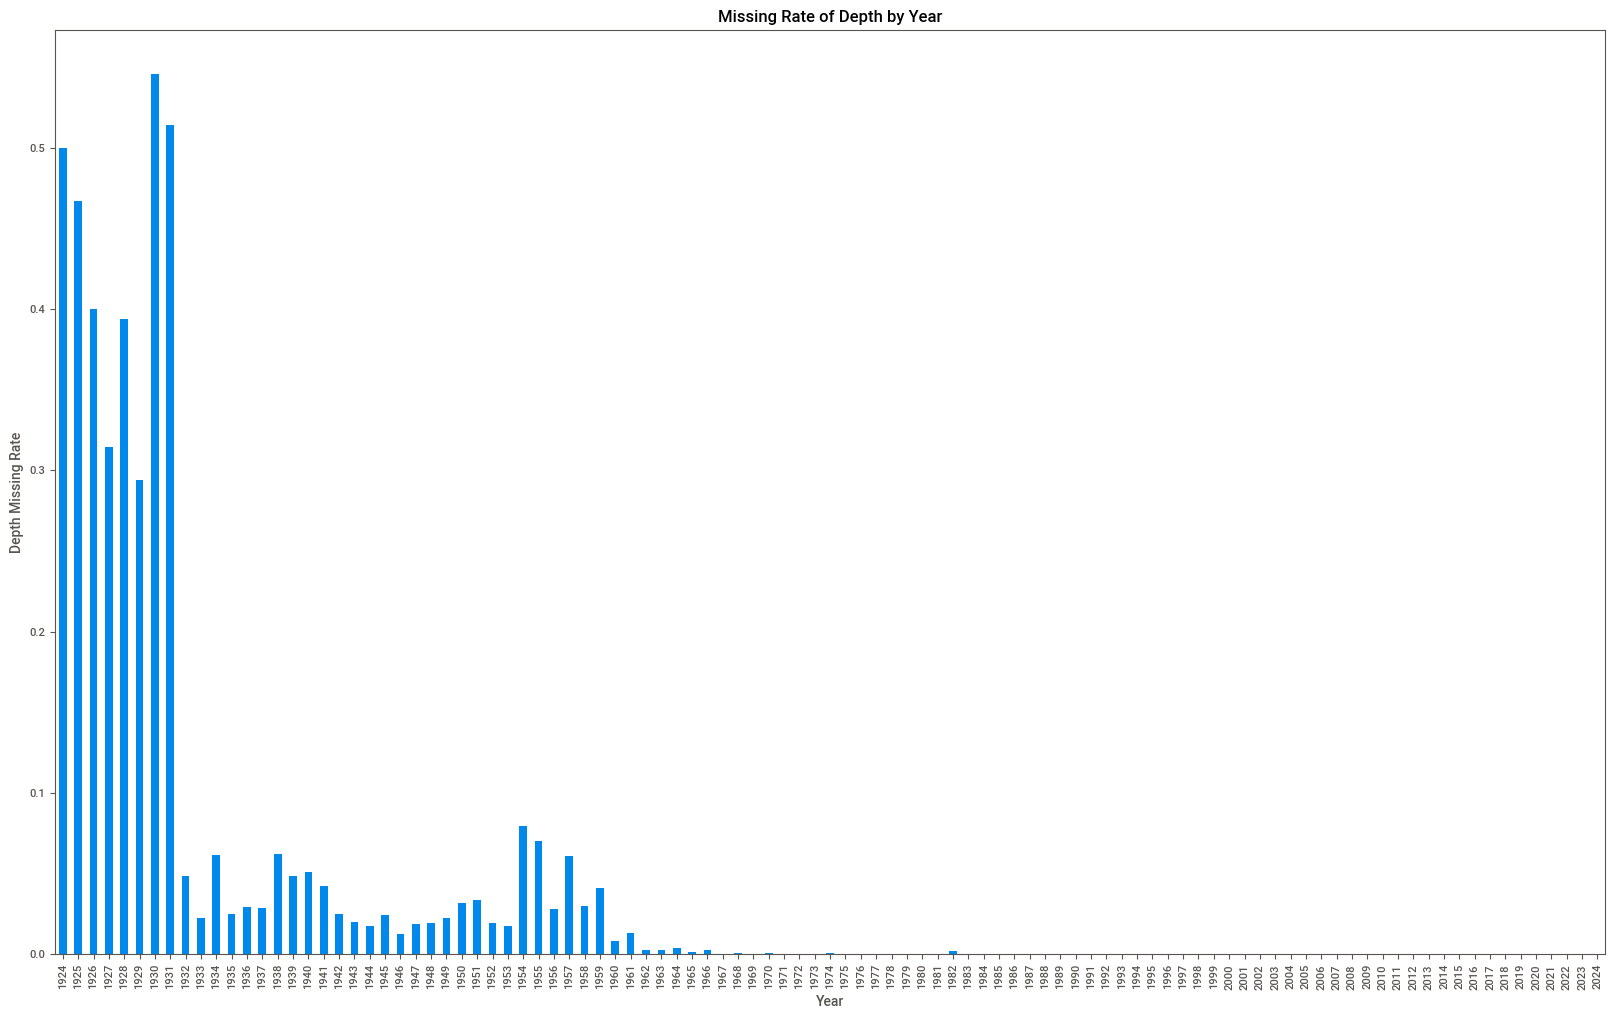

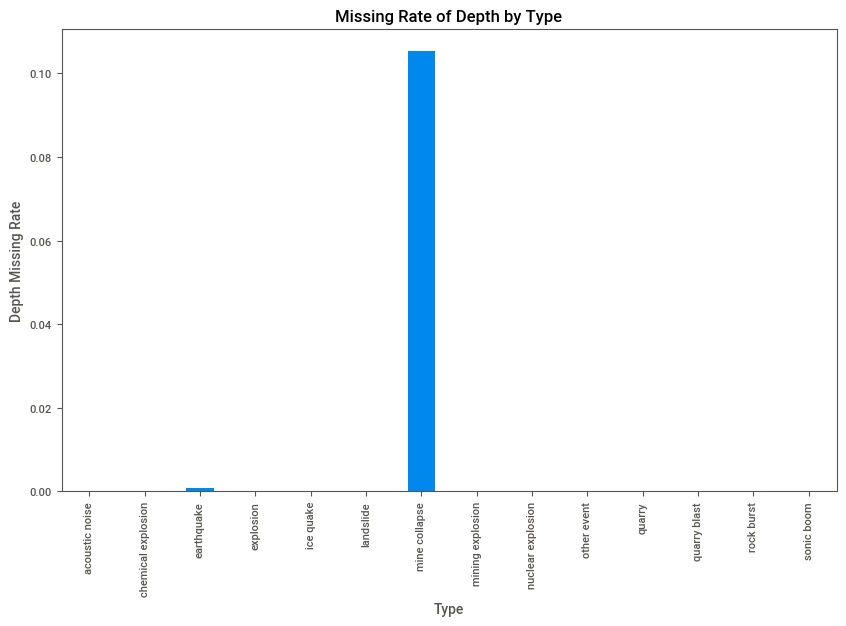

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns


# Depth by Year
missing_depth_by_year = missing_by_year['depth']
missing_depth_by_year.plot(kind='bar', figsize=(20,12))
plt.xlabel('Year')
plt.ylabel('Depth Missing Rate')
plt.title('Missing Rate of Depth by Year')
plt.show()

# Depth by Type
missing_depth_by_type = missing_by_type['depth']
missing_depth_by_type.plot(kind='bar', figsize=(10,6))
plt.xlabel('Type')
plt.ylabel('Depth Missing Rate')
plt.title('Missing Rate of Depth by Type')
plt.show()

#### ↑1960年代までに欠損値が多い。mine collapseでの欠損がほとんど

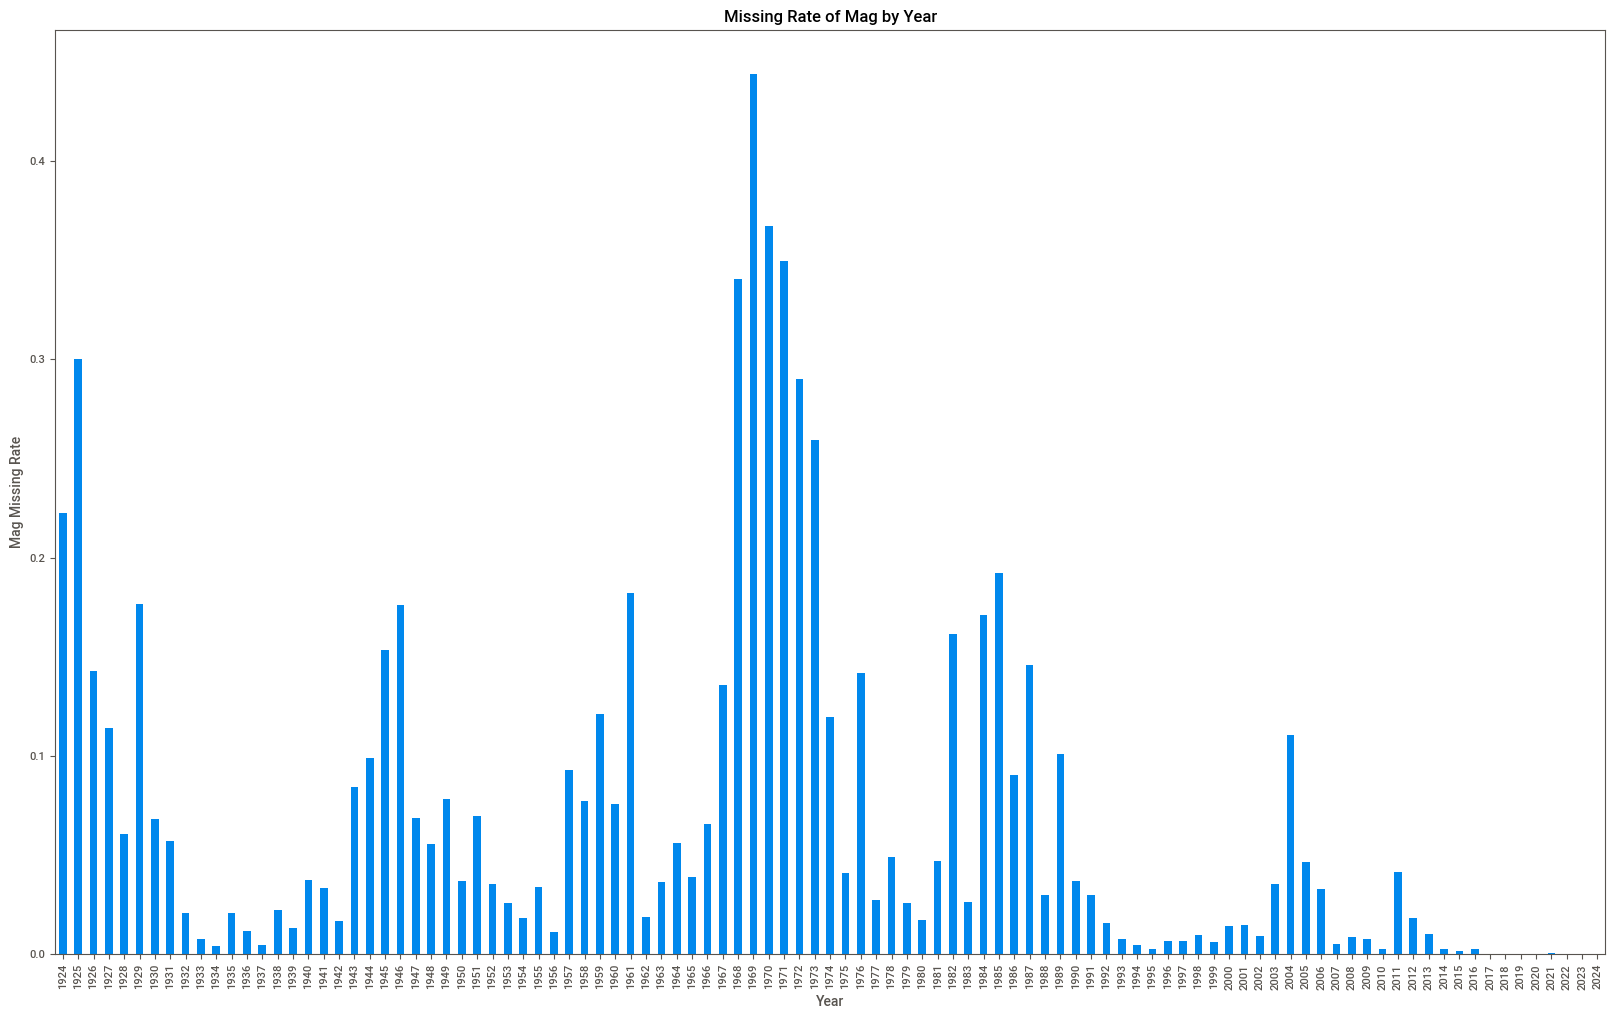

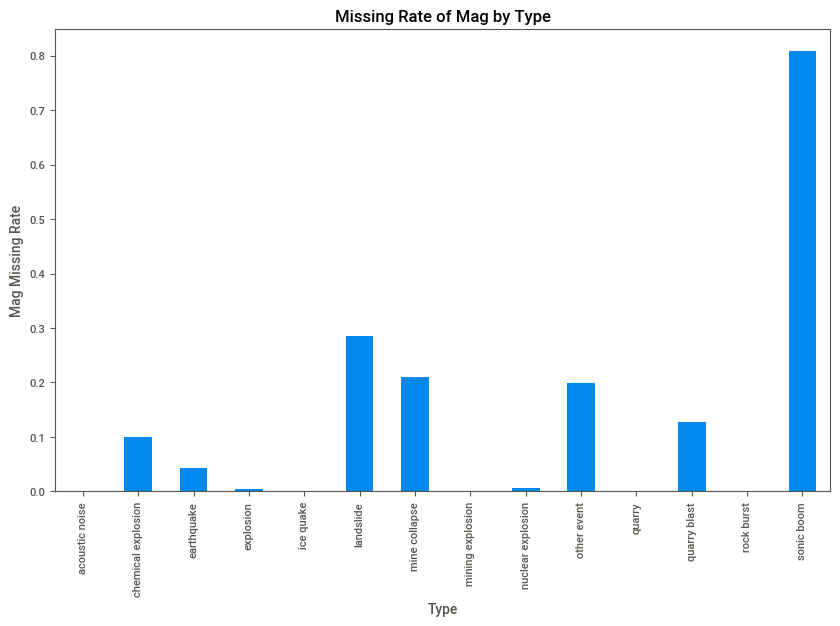

In [48]:
# Mag by Year
missing_mag_by_year = missing_by_year['mag']
missing_mag_by_year.plot(kind='bar', figsize=(20,12))
plt.xlabel('Year')
plt.ylabel('Mag Missing Rate')
plt.title('Missing Rate of Mag by Year')
plt.show()

# Mag by Type
missing_mag_by_type = missing_by_type['mag']
missing_mag_by_type.plot(kind='bar', figsize=(10,6))
plt.xlabel('Type')
plt.ylabel('Mag Missing Rate')
plt.title('Missing Rate of Mag by Type')
plt.show()

#### ↑地震以外での欠損値が多い

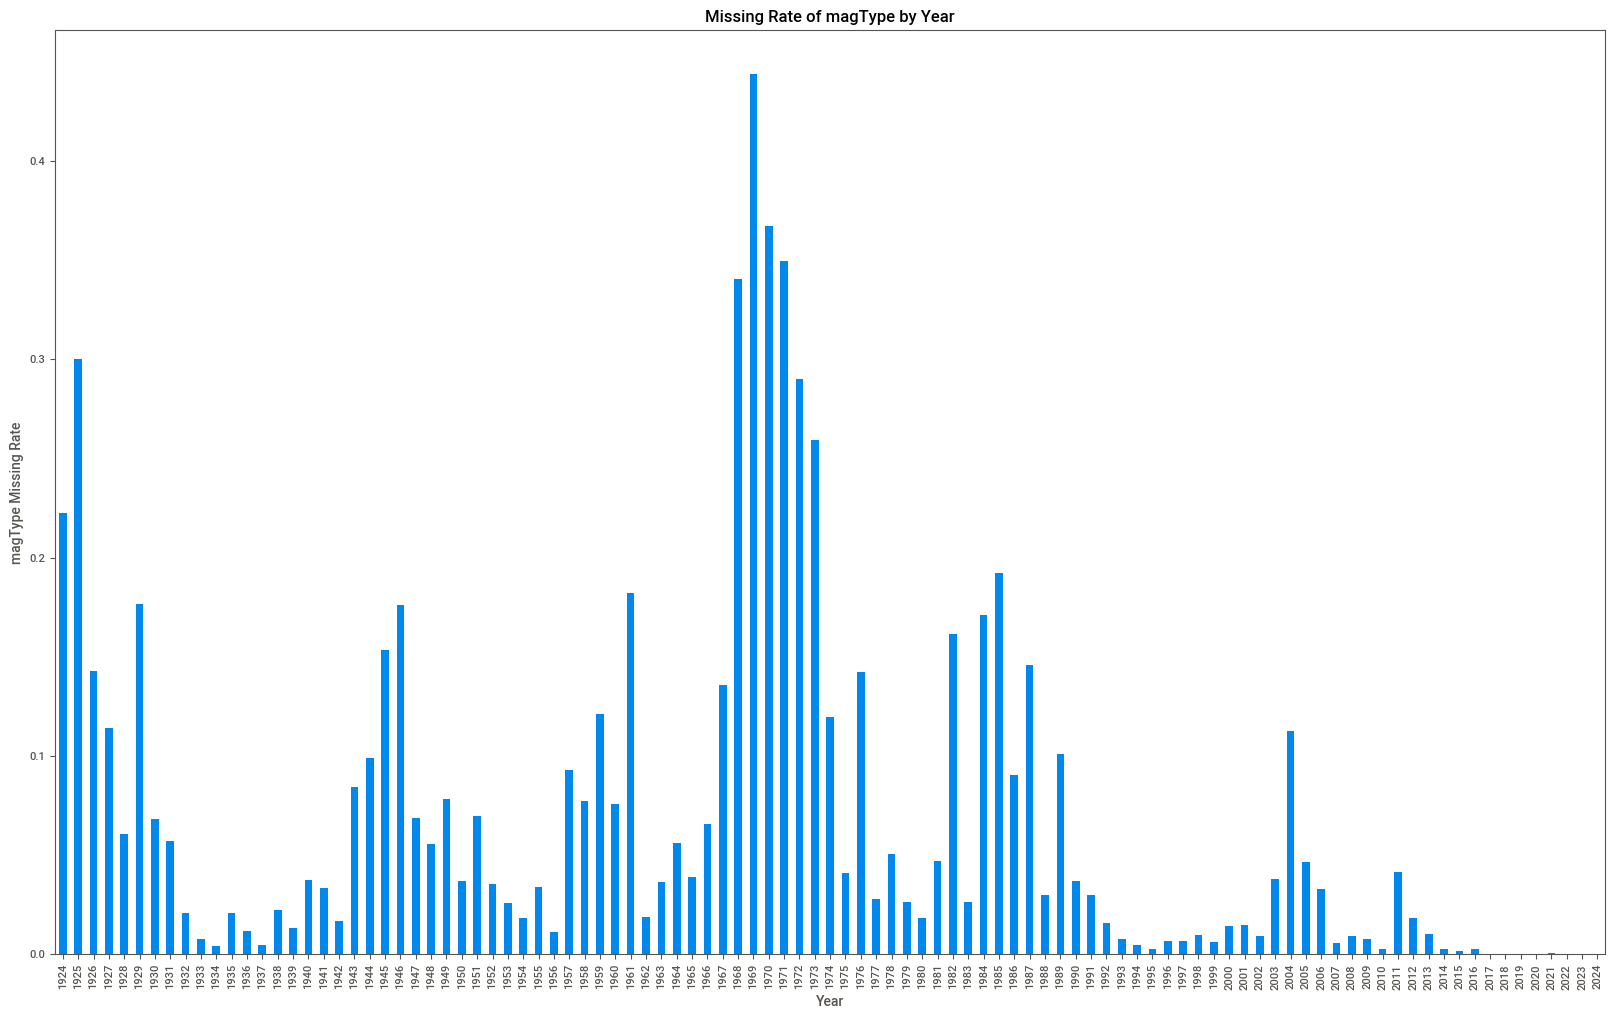

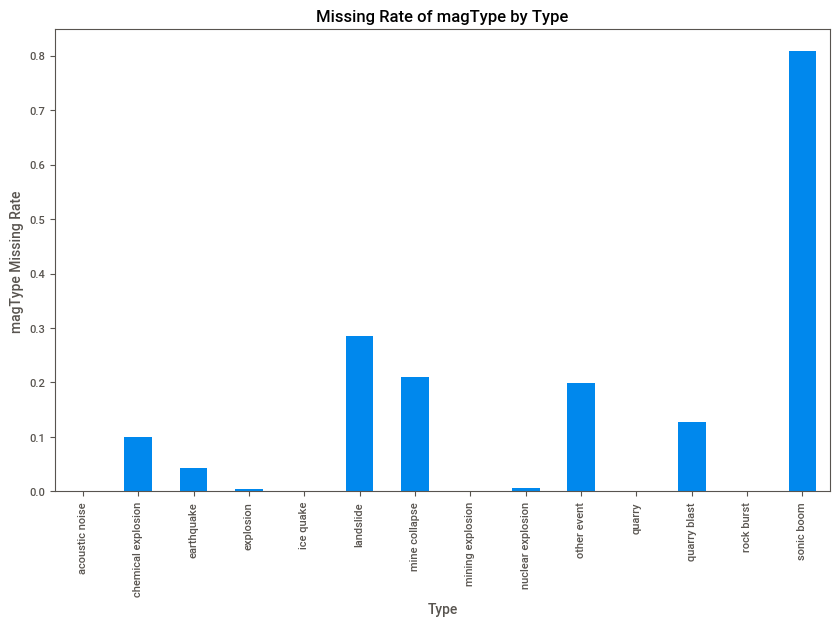

In [50]:
# magType by Year
missing_magType_by_year = missing_by_year['magType']
missing_magType_by_year.plot(kind='bar', figsize=(20,12))
plt.xlabel('Year')
plt.ylabel('magType Missing Rate')
plt.title('Missing Rate of magType by Year')
plt.show()

# magType by Type
missing_magType_by_type = missing_by_type['magType']
missing_magType_by_type.plot(kind='bar', figsize=(10,6))
plt.xlabel('Type')
plt.ylabel('magType Missing Rate')
plt.title('Missing Rate of magType by Type')
plt.show()

#### ↑magTypeも地震以外での欠損値が多い

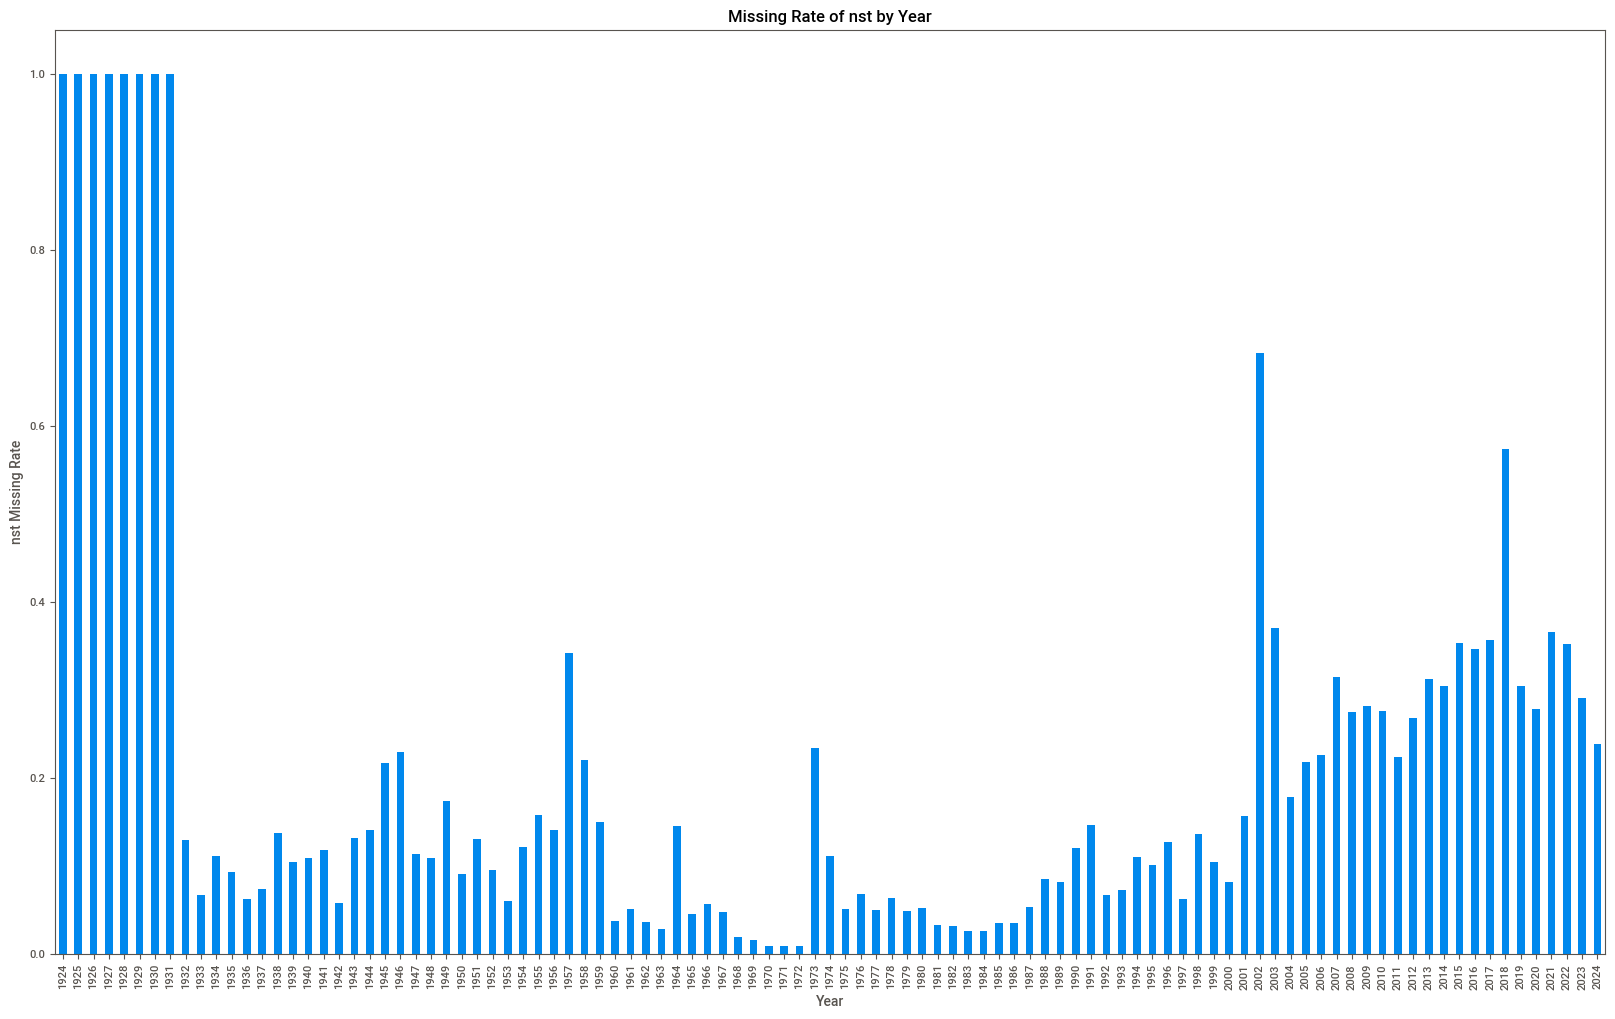

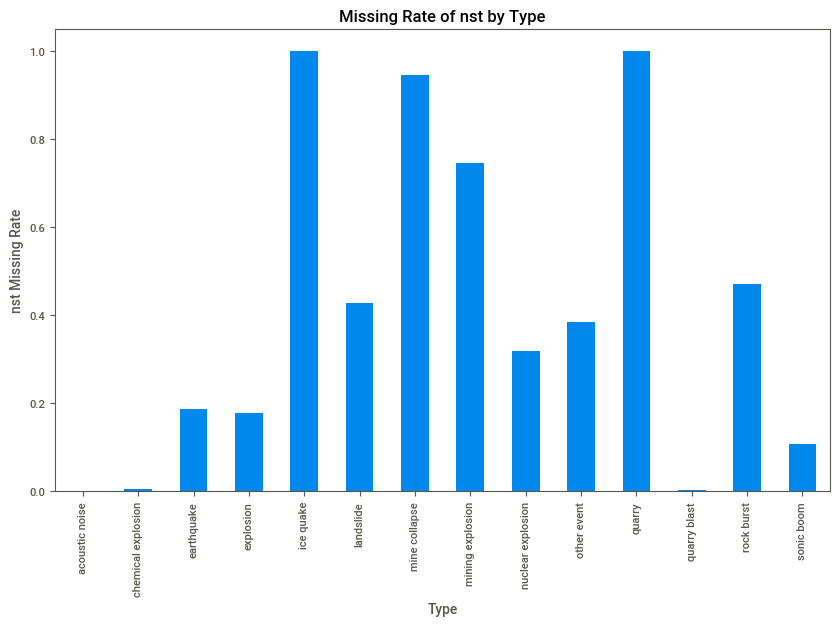

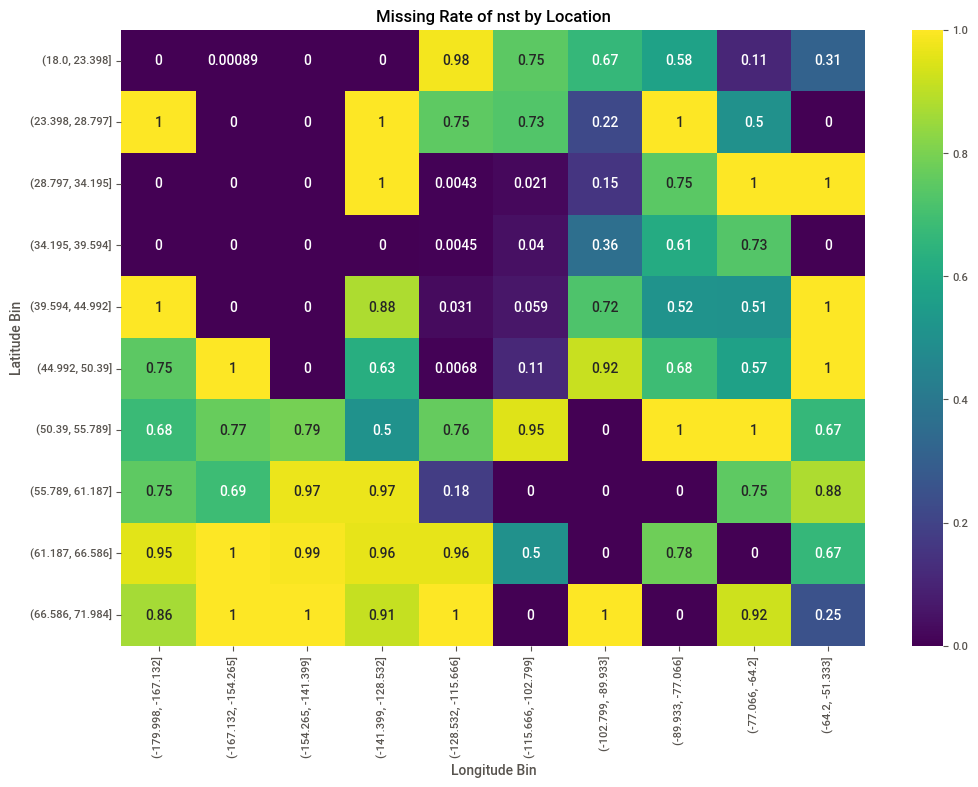

In [52]:
# nst by Year
missing_nst_by_year = missing_by_year['nst']
missing_nst_by_year.plot(kind='bar', figsize=(20,12))
plt.xlabel('Year')
plt.ylabel('nst Missing Rate')
plt.title('Missing Rate of nst by Year')
plt.show()

# nst by Type
missing_nst_by_type = missing_by_type['nst']
missing_nst_by_type.plot(kind='bar', figsize=(10,6))
plt.xlabel('Type')
plt.ylabel('nst Missing Rate')
plt.title('Missing Rate of nst by Type')
plt.show()

#nst by location
# 緯度、経度のビンを作成する（例：10個のビン）
lat_bins = np.linspace(df['latitude'].min(), df['latitude'].max(), num=11)
lon_bins = np.linspace(df['longitude'].min(), df['longitude'].max(), num=11)

# 新たなカラムとしてビンを作成
df['lat_bin'] = pd.cut(df['latitude'], bins=lat_bins)
df['lon_bin'] = pd.cut(df['longitude'], bins=lon_bins)

# numpy の無効な値に関する警告を無視する
np.seterr(invalid='ignore')

# observedパラメータを明示的に指定
missing_nst_by_location = df.groupby(['lat_bin', 'lon_bin'], observed=False)['nst'].apply(lambda x: x.isnull().mean()).unstack()

plt.figure(figsize=(12,8))
sns.heatmap(missing_nst_by_location.fillna(0), annot=True, cmap='viridis')
plt.title('Missing Rate of nst by Location')
plt.xlabel('Longitude Bin')
plt.ylabel('Latitude Bin')
plt.show()


### ↑地震以外の欠損率が大きいが地震も20%占めている。ヒートマップから端の方で欠損率が大きいので、アメリカの端の方や海のあたりが観測局がカバーできていない

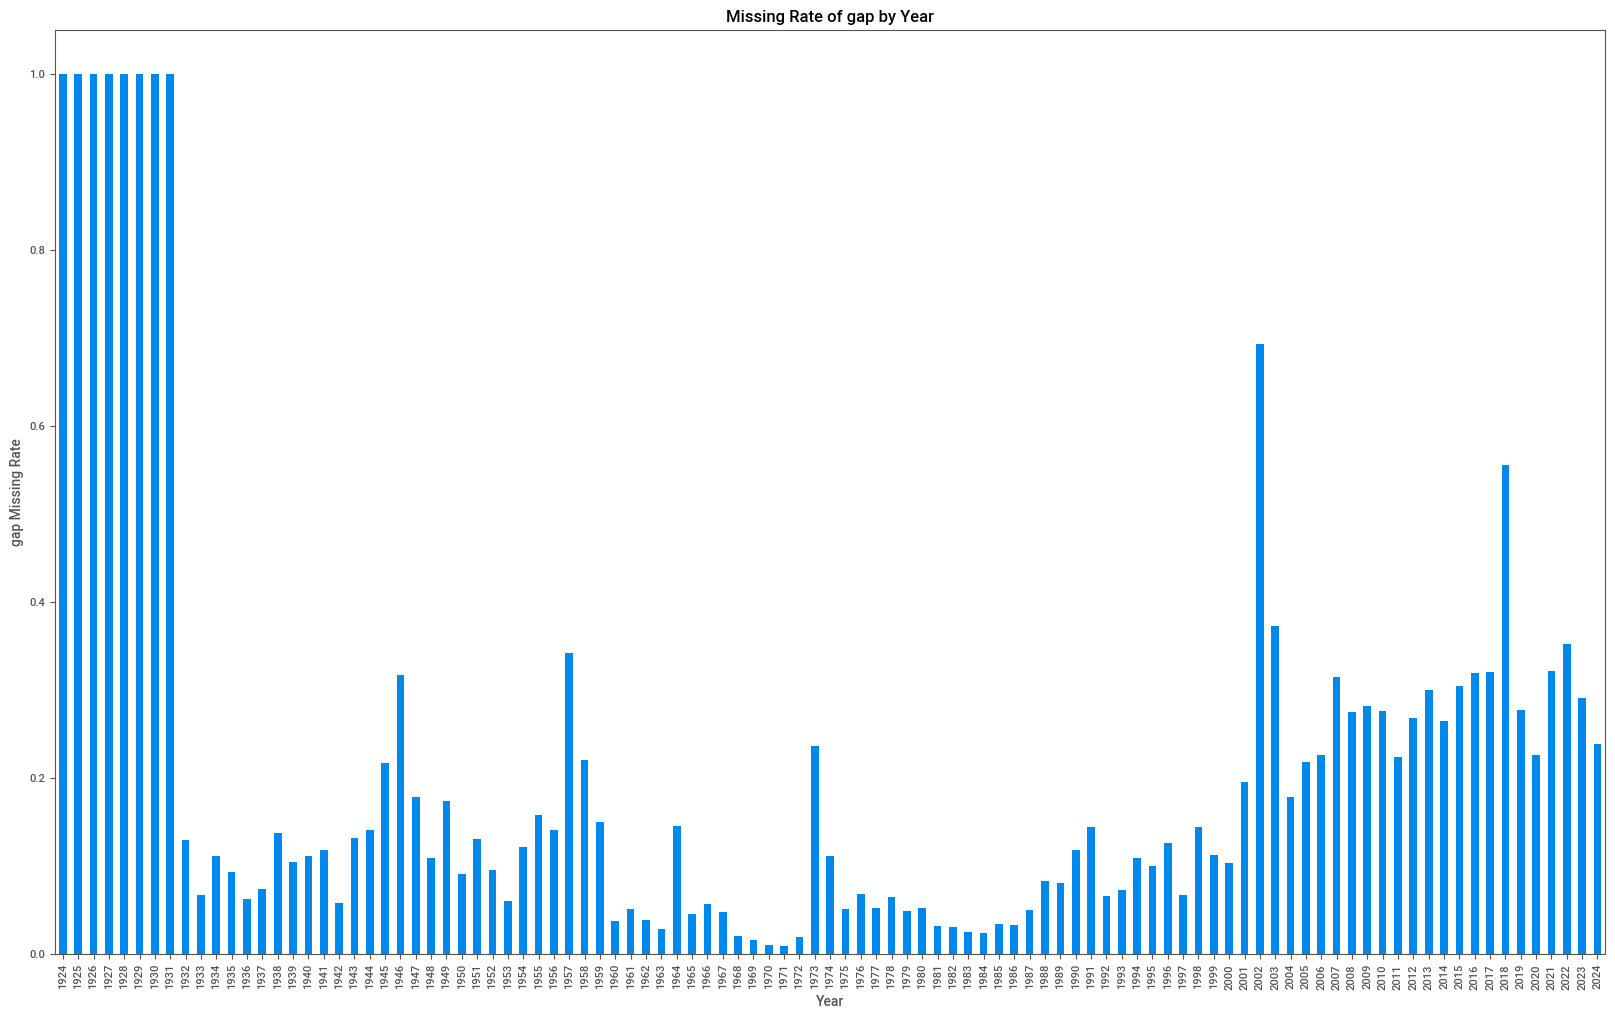

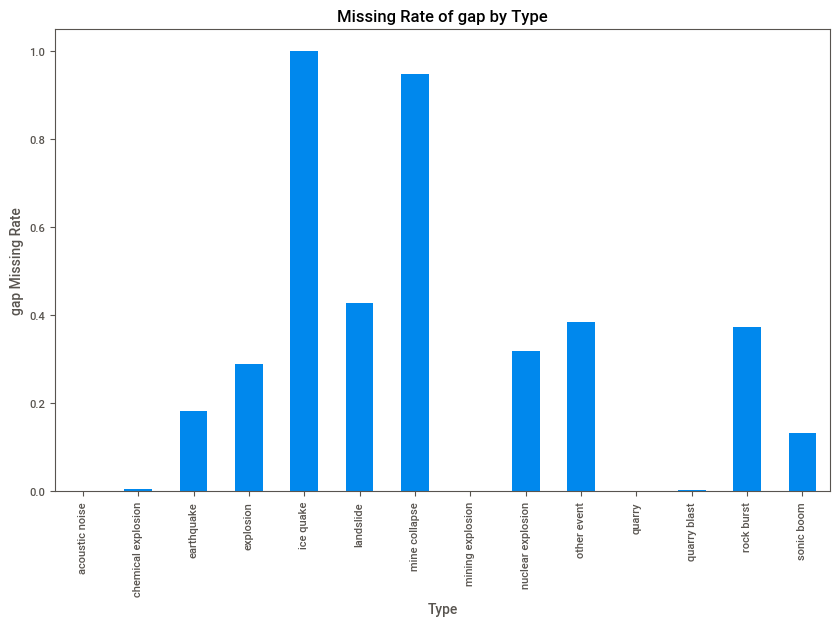

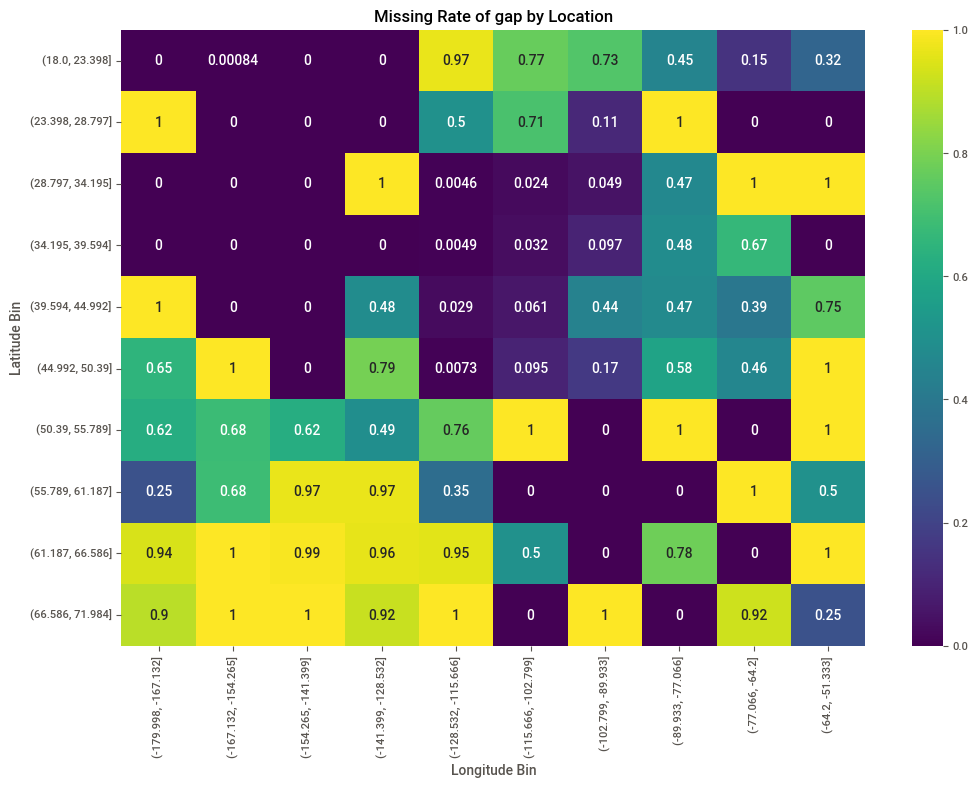

In [54]:
# gap by Year
missing_gap_by_year = missing_by_year['gap']
missing_gap_by_year.plot(kind='bar', figsize=(20,12))
plt.xlabel('Year')
plt.ylabel('gap Missing Rate')
plt.title('Missing Rate of gap by Year')
plt.show()

# gap by Type
missing_gap_by_type = missing_by_type['gap']
missing_gap_by_type.plot(kind='bar', figsize=(10,6))
plt.xlabel('Type')
plt.ylabel('gap Missing Rate')
plt.title('Missing Rate of gap by Type')
plt.show()

# observedパラメータを明示的に指定
missing_nst_by_location = df.groupby(['lat_bin', 'lon_bin'], observed=False)['gap'].apply(lambda x: x.isnull().mean()).unstack()

plt.figure(figsize=(12,8))
sns.heatmap(missing_nst_by_location.fillna(0), annot=True, cmap='viridis')
plt.title('Missing Rate of gap by Location')
plt.xlabel('Longitude Bin')
plt.ylabel('Latitude Bin')
plt.show()

#### ↑地震以外の欠損率が大きいが地震も20%占めている。ヒートマップから端の方で欠損率が大きいので、アメリカの端の方や海のあたりが観測局が少なくギャップができやすい

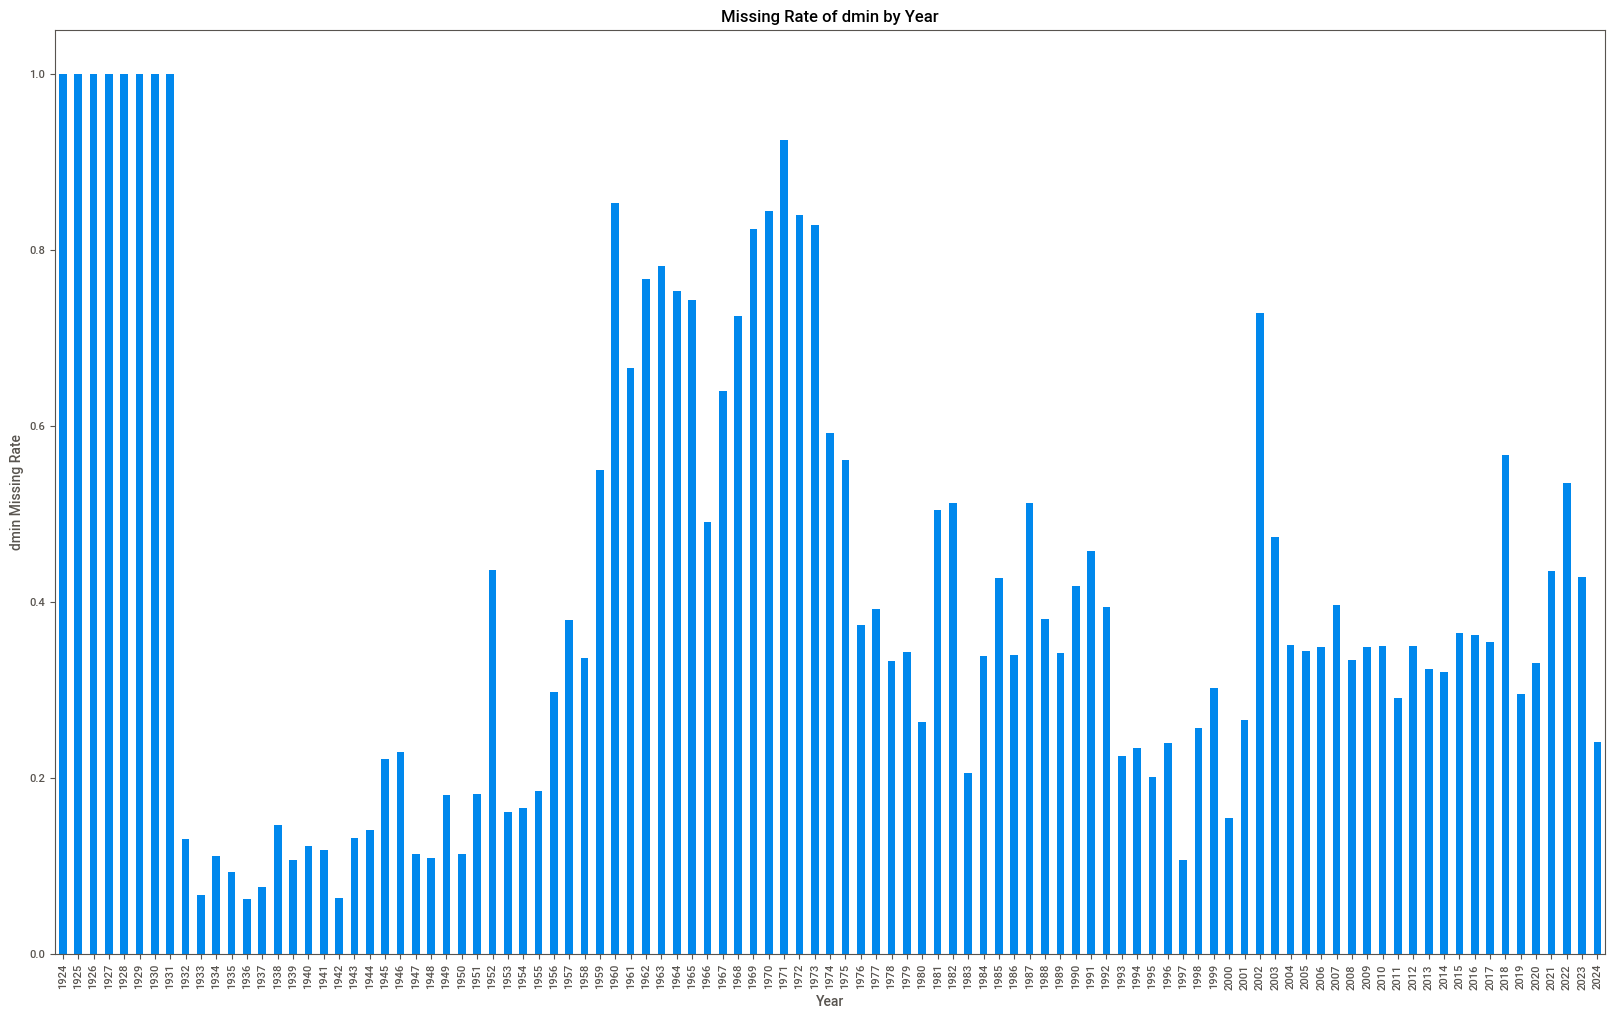

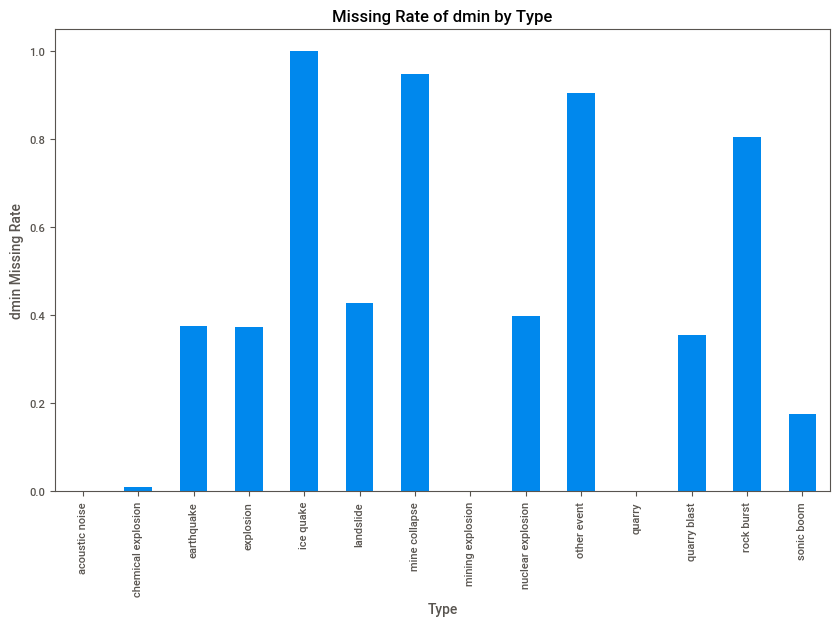

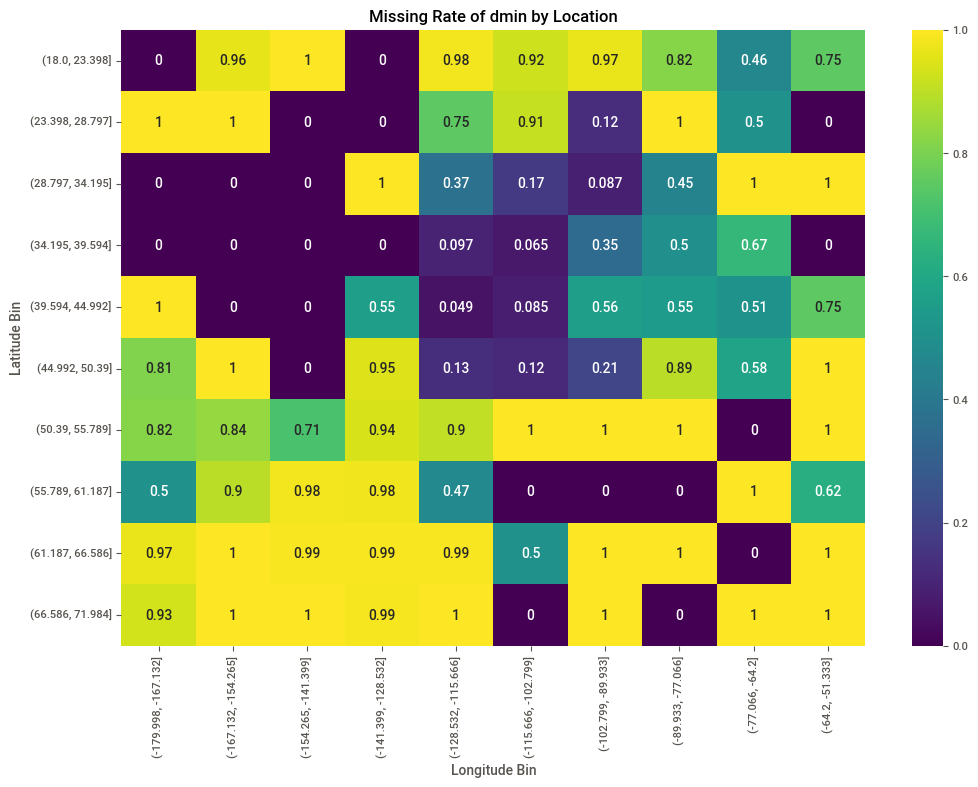

In [56]:
# dmin by Year
missing_dmin_by_year = missing_by_year['dmin']
missing_dmin_by_year.plot(kind='bar', figsize=(20,12))
plt.xlabel('Year')
plt.ylabel('dmin Missing Rate')
plt.title('Missing Rate of dmin by Year')
plt.show()

# dmin by Type
missing_dmin_by_type = missing_by_type['dmin']
missing_dmin_by_type.plot(kind='bar', figsize=(10,6))
plt.xlabel('Type')
plt.ylabel('dmin Missing Rate')
plt.title('Missing Rate of dmin by Type')
plt.show()

missing_nst_by_location = df.groupby(['lat_bin', 'lon_bin'], observed=False)['dmin'].apply(lambda x: x.isnull().mean()).unstack()

plt.figure(figsize=(12,8))
sns.heatmap(missing_nst_by_location.fillna(0), annot=True, cmap='viridis')
plt.title('Missing Rate of dmin by Location')
plt.xlabel('Longitude Bin')
plt.ylabel('Latitude Bin')
plt.show()

#### ↑地震以外の欠損率が大きいが地震も20%占めている。Latitudeが60~70あたりの欠損率が大きい

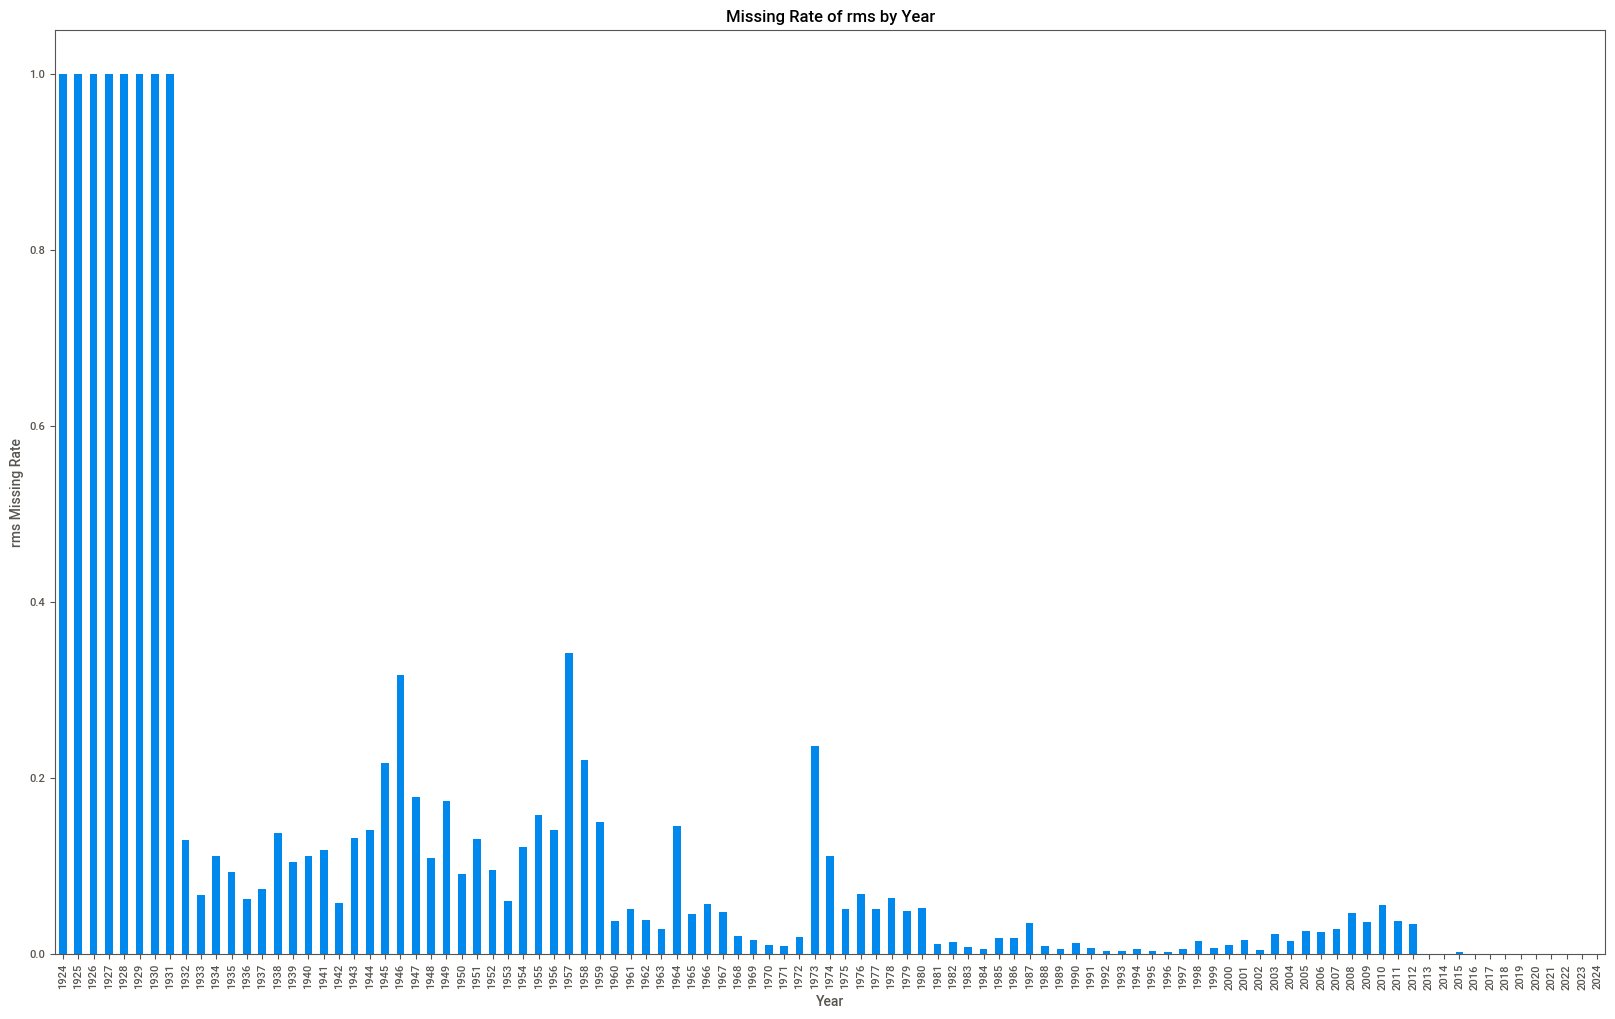

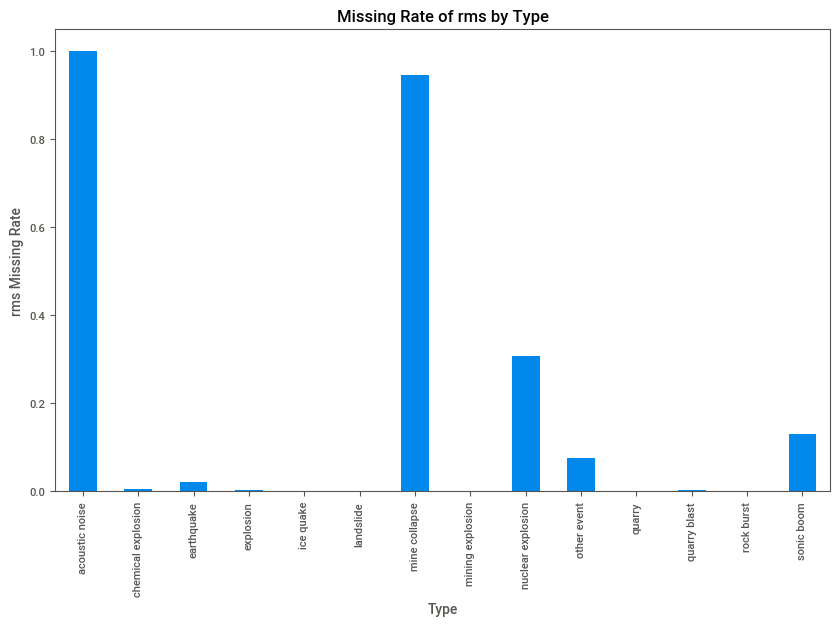

In [58]:
# rms by Year
missing_rms_by_year = missing_by_year['rms']
missing_rms_by_year.plot(kind='bar', figsize=(20,12))
plt.xlabel('Year')
plt.ylabel('rms Missing Rate')
plt.title('Missing Rate of rms by Year')
plt.show()

# rms by Type
missing_rms_by_type = missing_by_type['rms']
missing_rms_by_type.plot(kind='bar', figsize=(10,6))
plt.xlabel('Type')
plt.ylabel('rms Missing Rate')
plt.title('Missing Rate of rms by Type')
plt.show()


#### ↑1930年代の欠損率が100%、また地震の欠損率は１０%以下

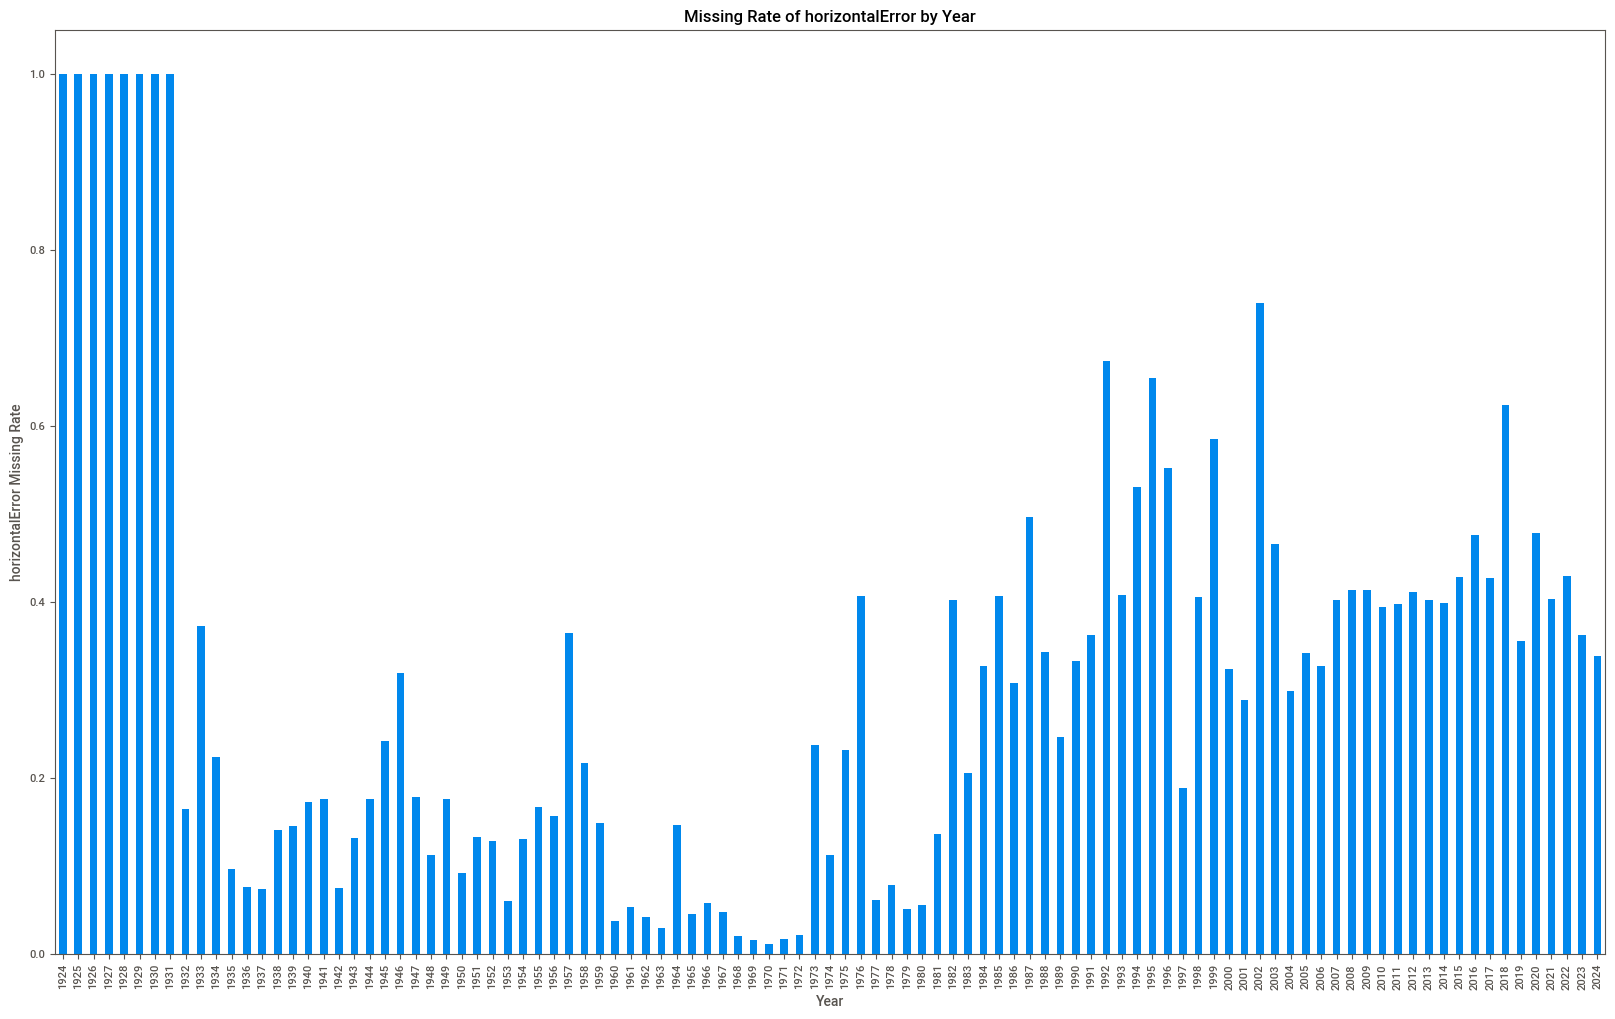

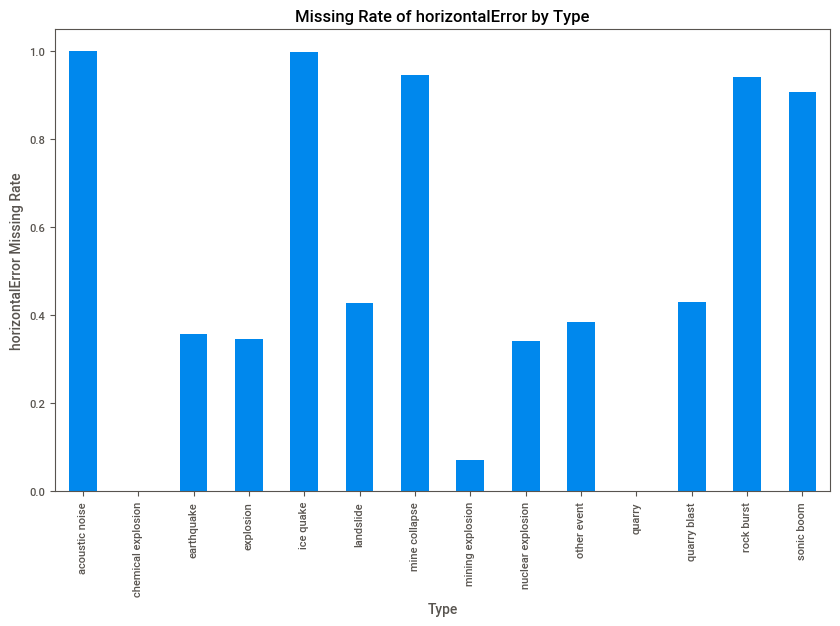

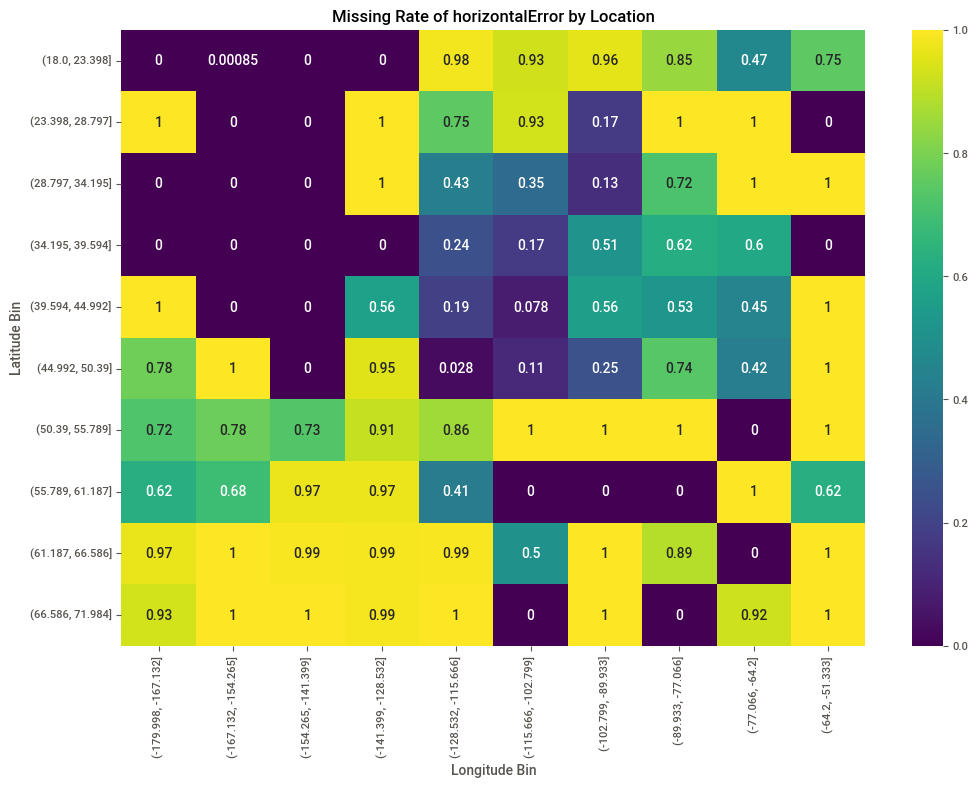

In [60]:
# horizontalError by Year
missing_horizontalError_by_year = missing_by_year['horizontalError']
missing_horizontalError_by_year.plot(kind='bar', figsize=(20,12))
plt.xlabel('Year')
plt.ylabel('horizontalError Missing Rate')
plt.title('Missing Rate of horizontalError by Year')
plt.show()

# horizontalError by Type
missing_horizontalError_by_type = missing_by_type['horizontalError']
missing_horizontalError_by_type.plot(kind='bar', figsize=(10,6))
plt.xlabel('Type')
plt.ylabel('horizontalError Missing Rate')
plt.title('Missing Rate of horizontalError by Type')
plt.show()

missing_horizontalError_by_location = df.groupby(['lat_bin', 'lon_bin'], observed=False)['horizontalError'].apply(lambda x: x.isnull().mean()).unstack()

plt.figure(figsize=(12,8))
sns.heatmap(missing_horizontalError_by_location.fillna(0), annot=True, cmap='viridis')
plt.title('Missing Rate of horizontalError by Location')
plt.xlabel('Longitude Bin')
plt.ylabel('Latitude Bin')
plt.show()

#### Latitudeが60〜70あたりの欠損率が高い

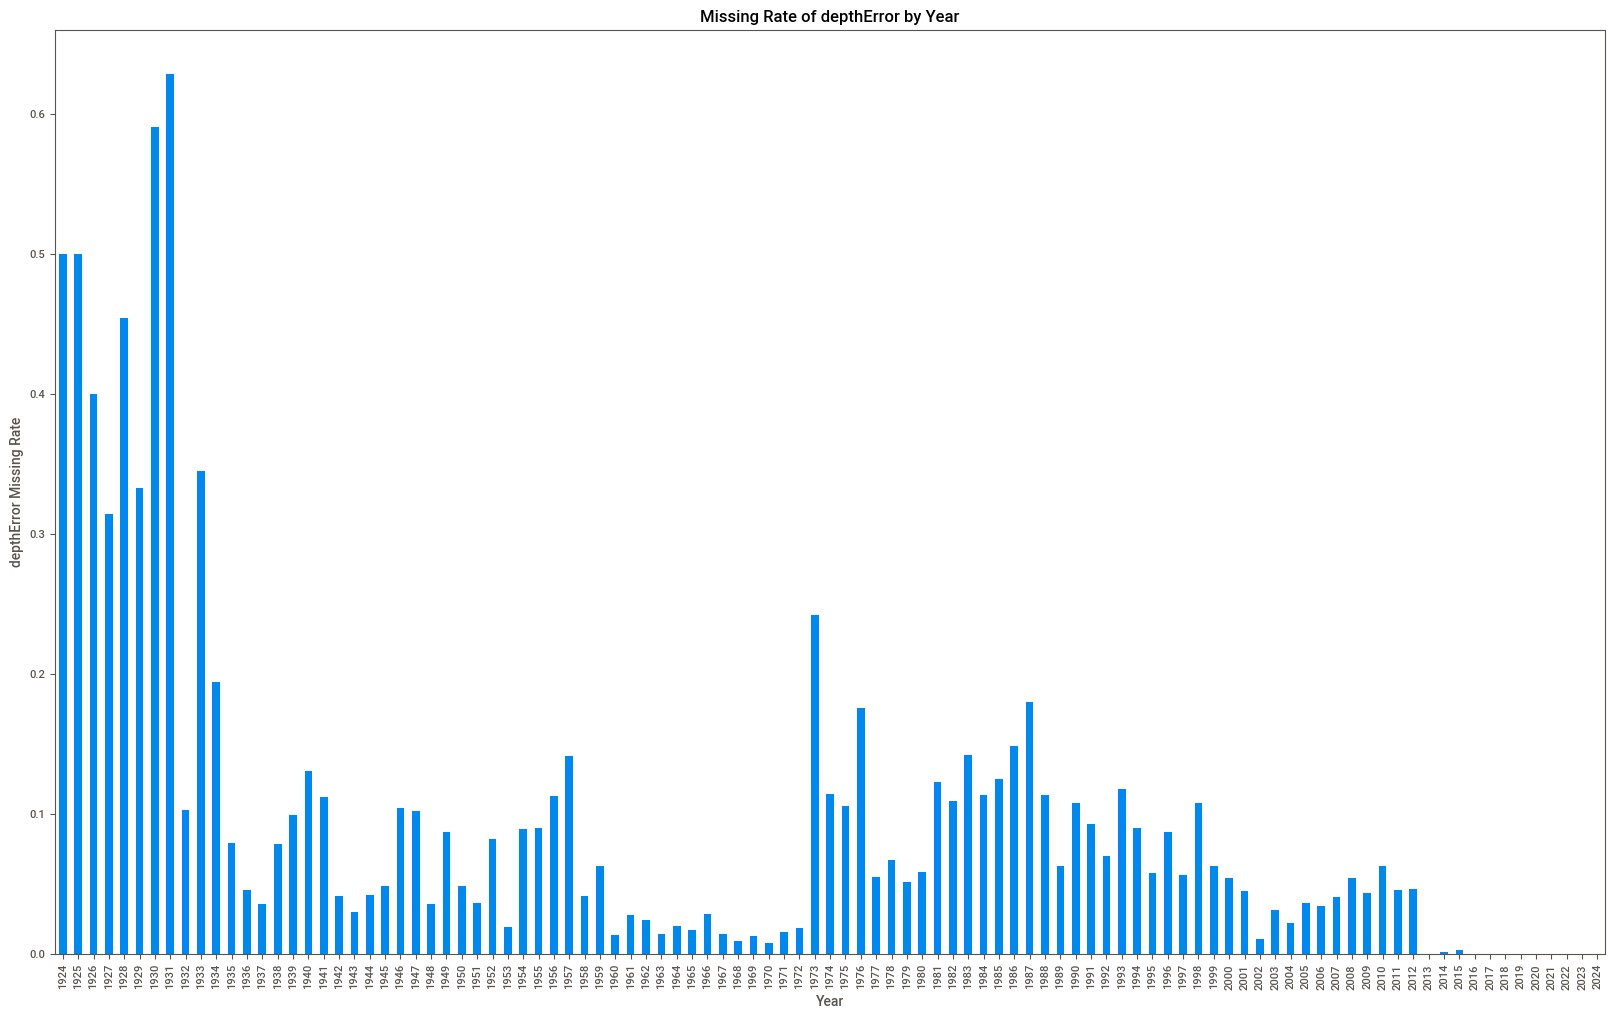

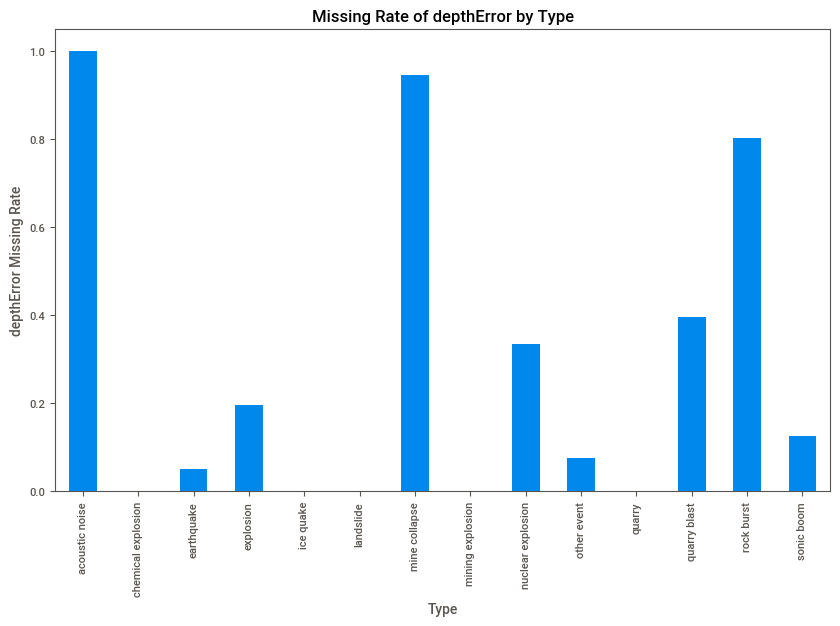

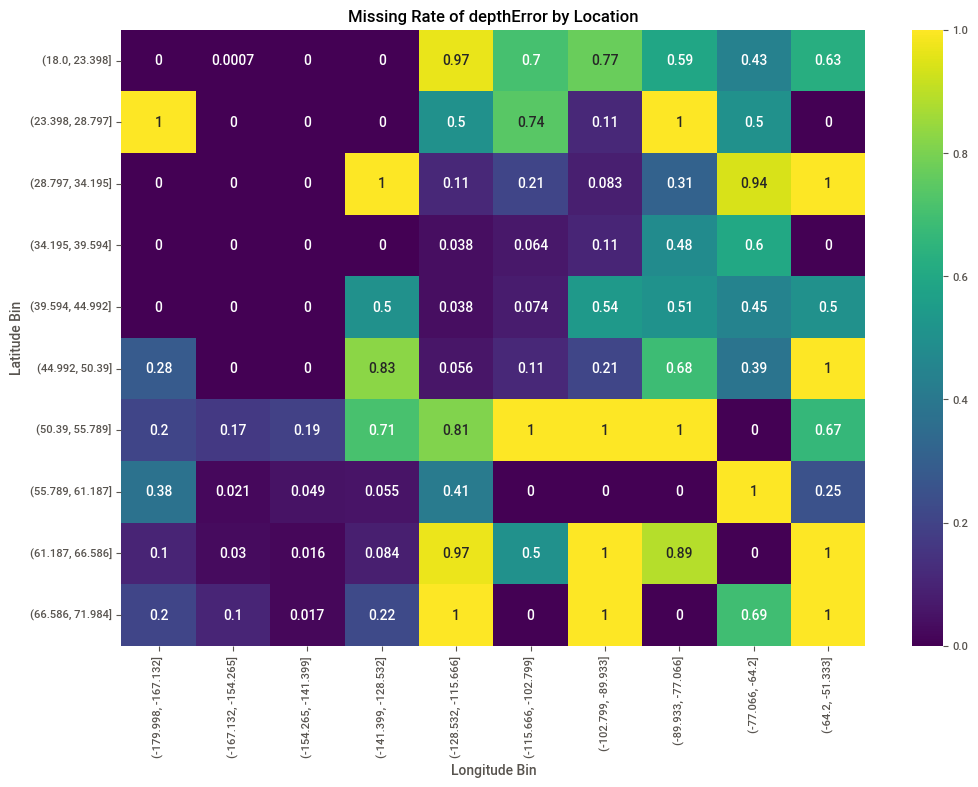

In [62]:
# depthError by Year
missing_depthError_by_year = missing_by_year['depthError']
missing_depthError_by_year.plot(kind='bar', figsize=(20,12))
plt.xlabel('Year')
plt.ylabel('depthError Missing Rate')
plt.title('Missing Rate of depthError by Year')
plt.show()

# depthError by Type
missing_depthError_by_type = missing_by_type['depthError']
missing_depthError_by_type.plot(kind='bar', figsize=(10,6))
plt.xlabel('Type')
plt.ylabel('depthError Missing Rate')
plt.title('Missing Rate of depthError by Type')
plt.show()

missing_depthError_by_location = df.groupby(['lat_bin', 'lon_bin'], observed=False)['depthError'].apply(lambda x: x.isnull().mean()).unstack()

plt.figure(figsize=(12,8))
sns.heatmap(missing_depthError_by_location.fillna(0), annot=True, cmap='viridis')
plt.title('Missing Rate of depthError by Location')
plt.xlabel('Longitude Bin')
plt.ylabel('Latitude Bin')
plt.show()

#### ↑地震の欠損率は全体の10%以下、ヒートマップの右側の欠損率が大きい

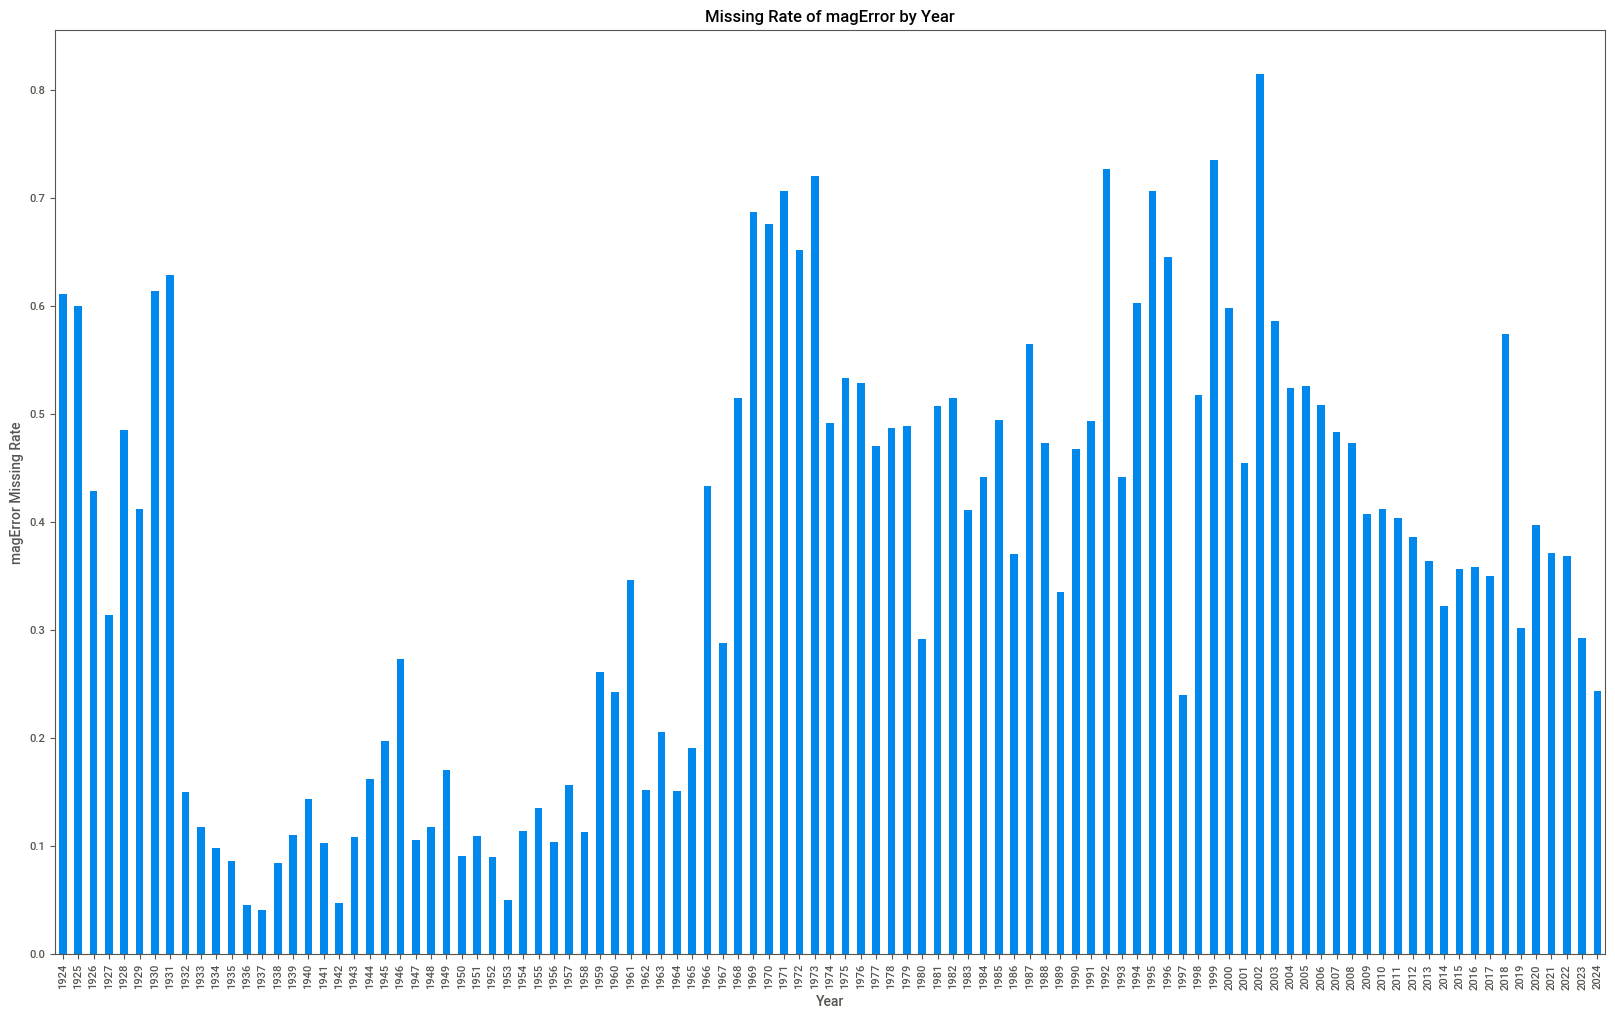

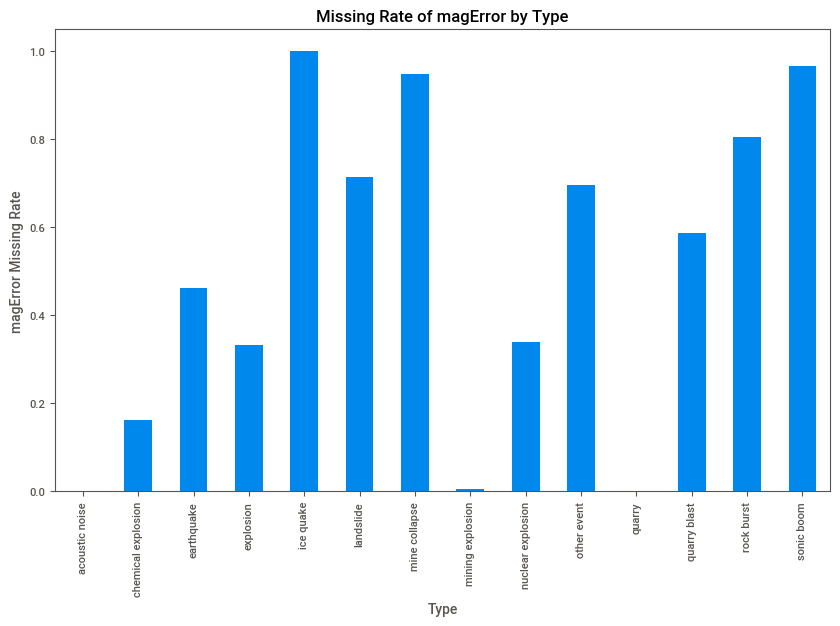

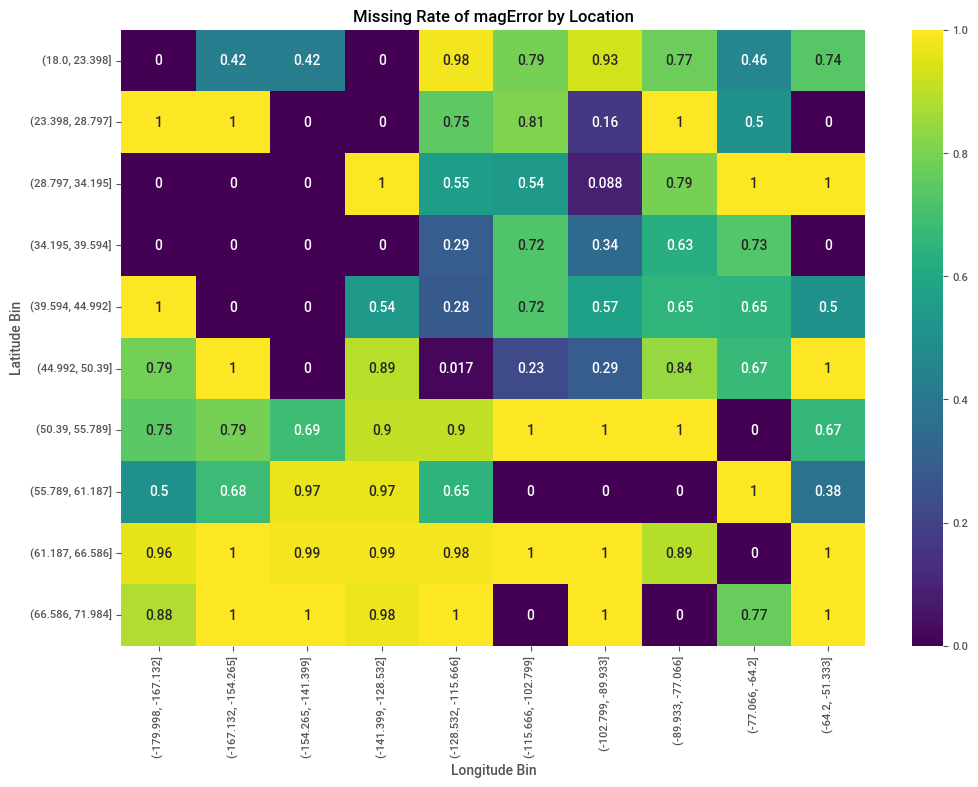

In [64]:
# magError by Year
missing_magError_by_year = missing_by_year['magError']
missing_magError_by_year.plot(kind='bar', figsize=(20,12))
plt.xlabel('Year')
plt.ylabel('magError Missing Rate')
plt.title('Missing Rate of magError by Year')
plt.show()

# magError by Type
missing_magError_by_type = missing_by_type['magError']
missing_magError_by_type.plot(kind='bar', figsize=(10,6))
plt.xlabel('Type')
plt.ylabel('magError Missing Rate')
plt.title('Missing Rate of magError by Type')
plt.show()

missing_magError_by_location = df.groupby(['lat_bin', 'lon_bin'], observed=False)['magError'].apply(lambda x: x.isnull().mean()).unstack()

plt.figure(figsize=(12,8))
sns.heatmap(missing_magError_by_location.fillna(0), annot=True, cmap='viridis')
plt.title('Missing Rate of magError by Location')
plt.xlabel('Longitude Bin')
plt.ylabel('Latitude Bin')
plt.show()

#### ↑地震の欠損率が全体の50%近くあり大きい、Latitudeが60~70あたりで欠損率が大きい

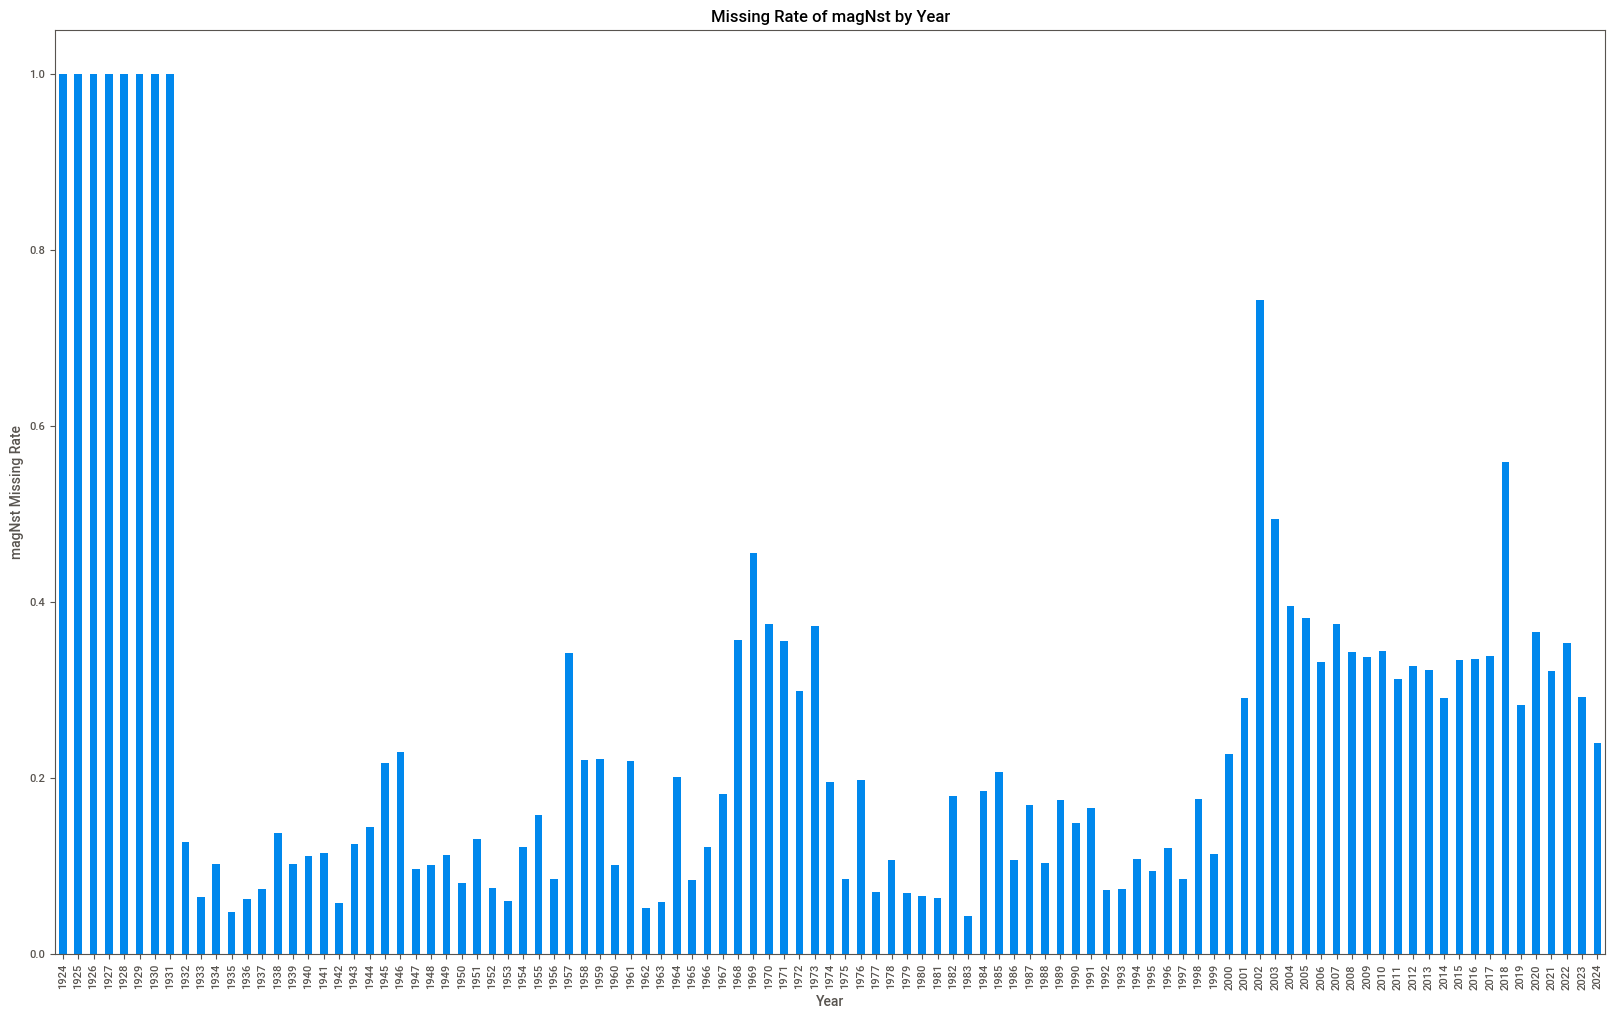

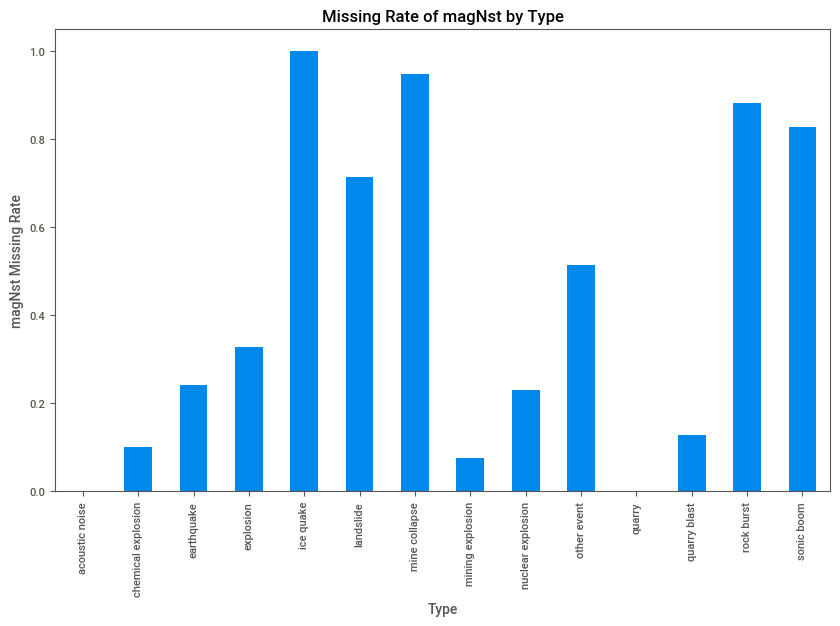

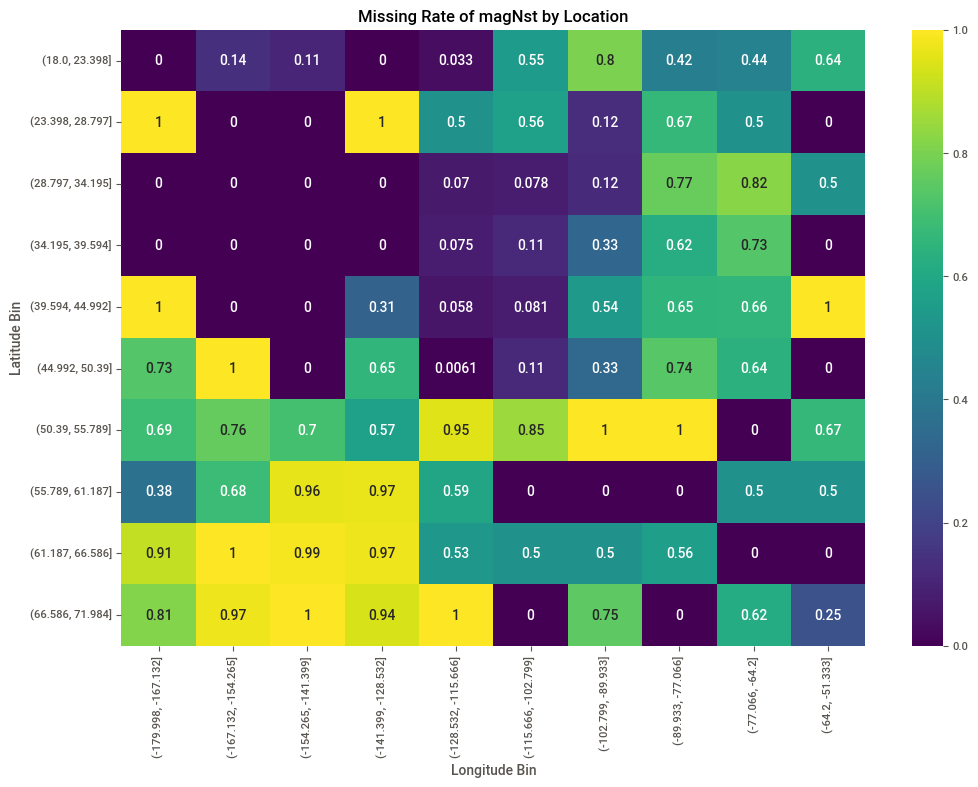

In [66]:
# magNst by Year
missing_magNst_by_year = missing_by_year['magNst']
missing_magNst_by_year.plot(kind='bar', figsize=(20,12))
plt.xlabel('Year')
plt.ylabel('magNst Missing Rate')
plt.title('Missing Rate of magNst by Year')
plt.show()

# magNst by Type
missing_magNst_by_type = missing_by_type['magNst']
missing_magNst_by_type.plot(kind='bar', figsize=(10,6))
plt.xlabel('Type')
plt.ylabel('magNst Missing Rate')
plt.title('Missing Rate of magNst by Type')
plt.show()

missing_magNst_by_location = df.groupby(['lat_bin', 'lon_bin'], observed=False)['magNst'].apply(lambda x: x.isnull().mean()).unstack()

plt.figure(figsize=(12,8))
sns.heatmap(missing_magNst_by_location.fillna(0), annot=True, cmap='viridis')
plt.title('Missing Rate of magNst by Location')
plt.xlabel('Longitude Bin')
plt.ylabel('Latitude Bin')
plt.show()

#### ↑ヒートマップの端の方が欠損率が大きい傾向にある

### 外れ値の確認

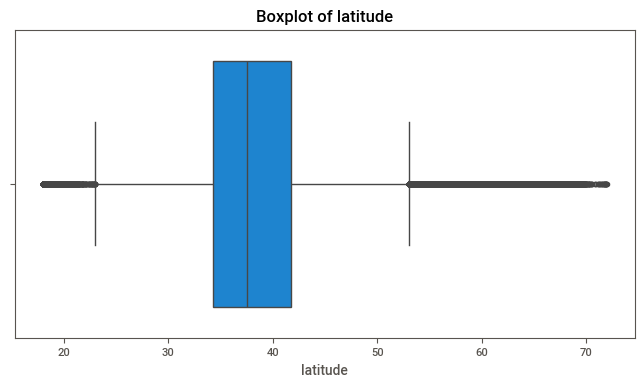

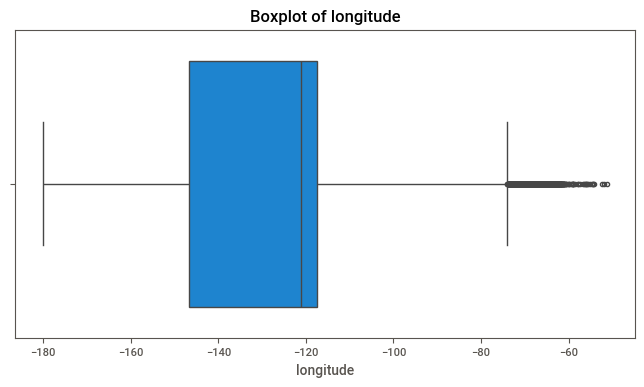

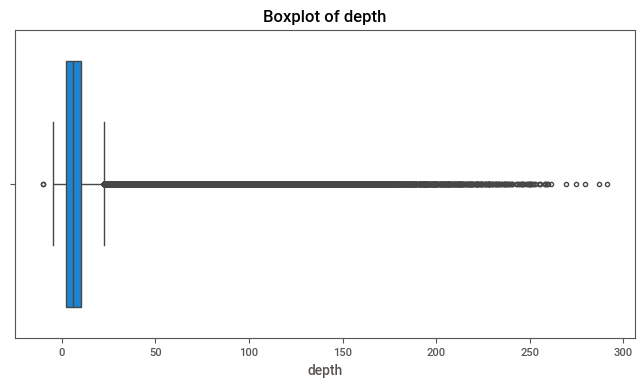

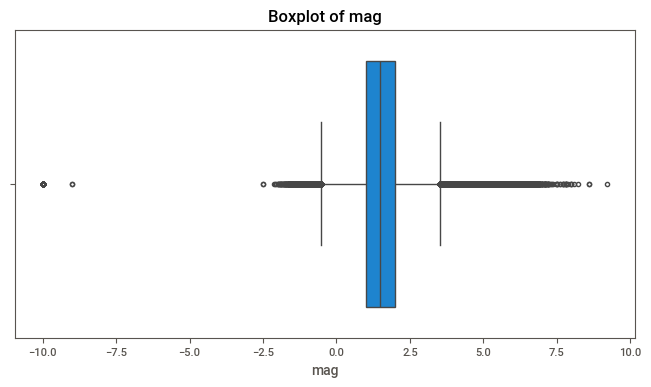

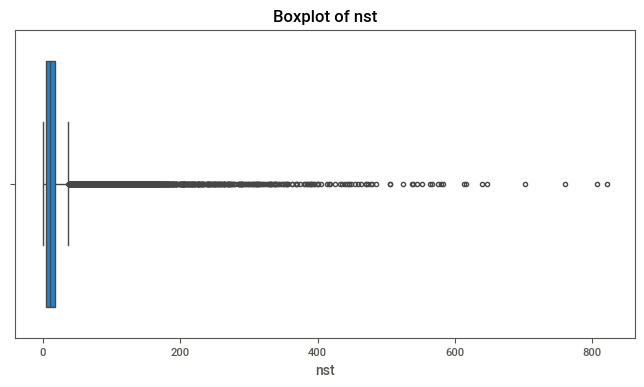

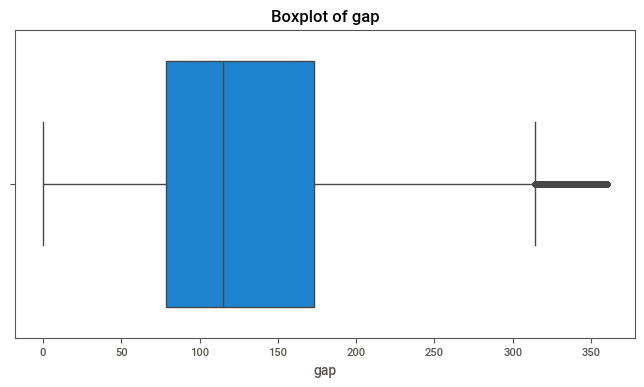

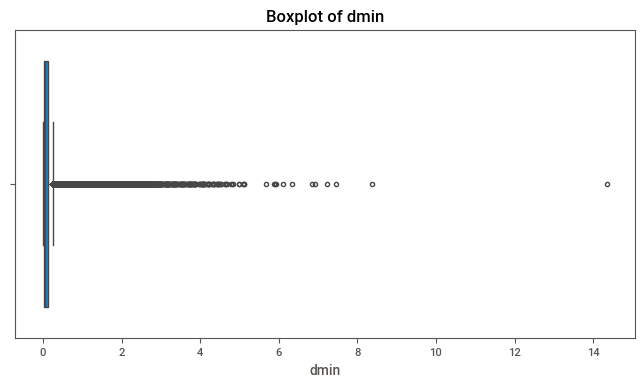

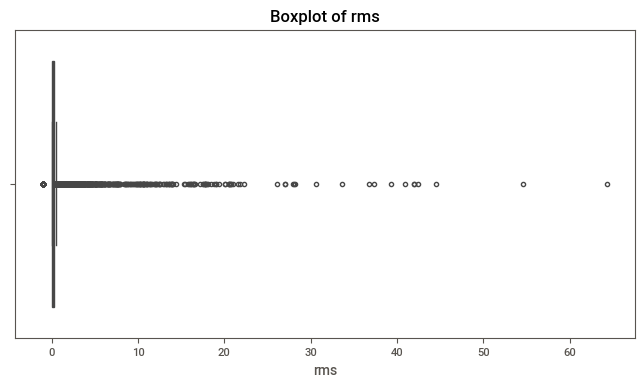

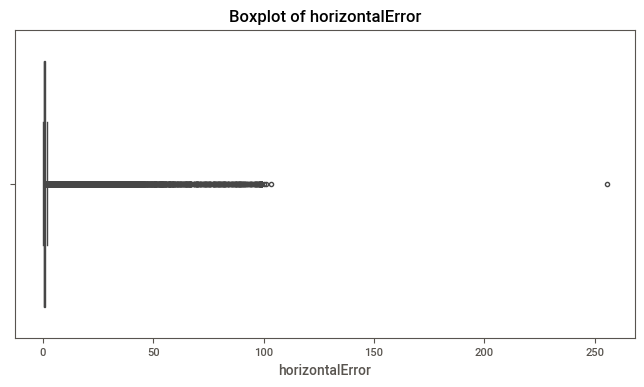

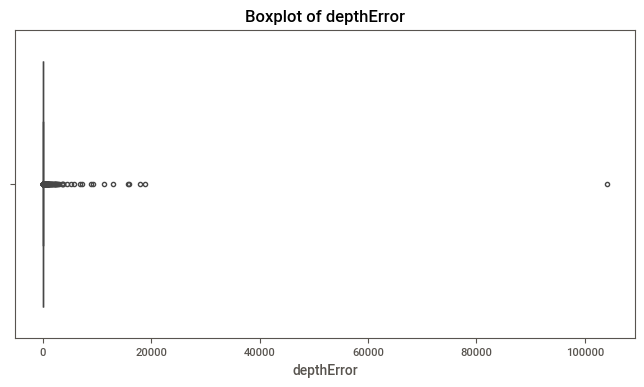

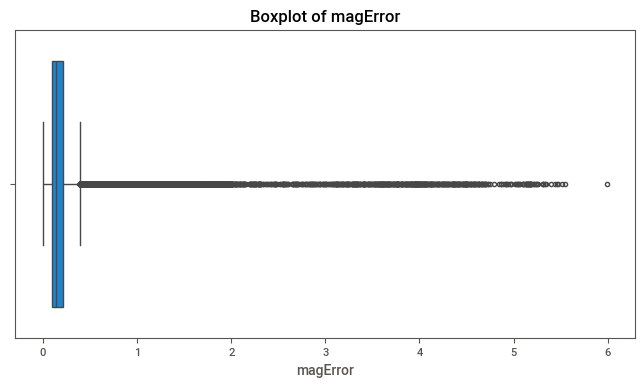

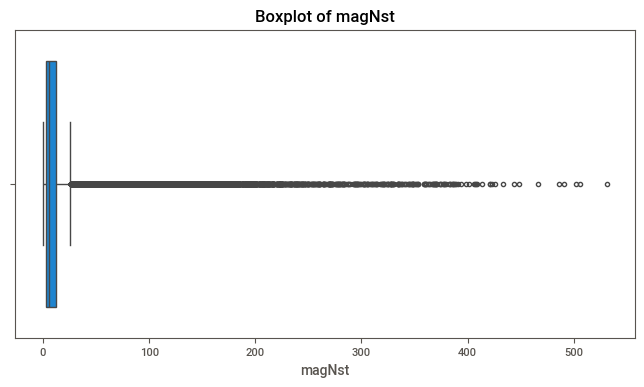

latitude: lower_bound=23.006500000000003, upper_bound=53.042500000000004, lower_outliers=109914, upper_outliers=172641
longitude: lower_bound=-190.17924995000004, upper_bound=-73.98311674999997, lower_outliers=0, upper_outliers=9383
depth: lower_bound=-9.465, upper_bound=22.494999999999997, lower_outliers=2, upper_outliers=119227
mag: lower_bound=-0.5149999999999997, upper_bound=3.5249999999999995, lower_outliers=4082, upper_outliers=24845
nst: lower_bound=-14.5, upper_bound=37.5, lower_outliers=0, upper_outliers=46315
gap: lower_bound=-62.749999999999986, upper_bound=314.45, lower_outliers=0, upper_outliers=17918
dmin: lower_bound=-0.11395000000000001, upper_bound=0.24997000000000003, lower_outliers=0, upper_outliers=66109
rms: lower_bound=-0.21724999999999997, upper_bound=0.49834999999999996, lower_outliers=79, upper_outliers=106835
horizontalError: lower_bound=-0.6949999999999998, upper_bound=1.9849999999999999, lower_outliers=0, upper_outliers=77415
depthError: lower_bound=-1.87, u

In [69]:
# 数値カラムのみを抽出
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

# 各数値カラムについて箱ひげ図を表示
for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)
    plt.show()

# IQR (四分位範囲) を用いて各カラムの外れ値閾値を計算
outlier_info = {}
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outlier_info[col] = {
        'lower_bound': lower_bound,
        'upper_bound': upper_bound,
        'outliers_lower': df[df[col] < lower_bound][col].count(),
        'outliers_upper': df[df[col] > upper_bound][col].count()
    }
    
# 結果の表示
for col, info in outlier_info.items():
    print(f"{col}: lower_bound={info['lower_bound']}, upper_bound={info['upper_bound']}, "
          f"lower_outliers={info['outliers_lower']}, upper_outliers={info['outliers_upper']}")


### 箱ひげ図の結果
Latitude、Longitude、gapは比較的綺麗な箱ひげ図になっている  
magは箱が小さいが、形になっている
他のカラムは左に極端に偏って、右にひげが伸びている

### 相関関係の確認

In [72]:
# 数値型のカラムだけを抽出
numeric_df = df.select_dtypes(include=[np.number])

# 相関行列を計算
corr_matrix = numeric_df.corr()

# 相関行列を長い形式に変換
corr_pairs = corr_matrix.unstack()

# 自己相関（各変数との相関係数=1）を除外
corr_pairs = corr_pairs[corr_pairs < 1]

# 重複するペア (A,B と B,A) を削除
corr_pairs = corr_pairs.drop_duplicates()

# 絶対値が大きい順にソートして表示
sorted_corr = corr_pairs.reindex(corr_pairs.abs().sort_values(ascending=False).index)
print(sorted_corr.to_string())


mag              dmin               0.451634
gap              dmin               0.450241
dmin             horizontalError    0.442409
rms              horizontalError    0.430827
nst              magNst             0.398124
latitude         depth              0.388802
dmin             depthError         0.387256
latitude         year               0.384306
                 rms                0.368331
longitude        depth             -0.360981
horizontalError  depthError         0.349343
nst              gap               -0.335659
gap              horizontalError    0.335202
mag              year              -0.331206
latitude         longitude         -0.316652
dmin             rms                0.315503
gap              depthError         0.278440
mag              nst                0.265169
                 magNst             0.258364
                 rms                0.245244
gap              magNst            -0.238883
longitude        rms               -0.235541
depth     

#### 最大でも0.4ほどで強い相関関係は見当たらない